In [124]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import math
import pylab as pl
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import silhouette_samples, silhouette_score

In [125]:
#flipped columns because I made a misatake earlier and switched longitude with latitude

LiquorData = pd.read_csv("2017-2018Liquor.csv")
LiquorData.rename(columns = {'longitude':'Latitude', 'latitude':'Longitude'}, inplace = True)
CrimeData = pd.read_csv("2017-2018Crime.csv")
CrimeData.rename(columns = {'longitude':'Latitude', 'latitude':'Longitude'}, inplace = True)

#printing this to demonstrate how crime data is cleaned in subsequent steps. 
print(len(CrimeData))

734112


# Data Cleaning:

### Here I am removing outliers from the crime dataset as well as removing anything outside of the easternmost, northernmost, westernmost, or southernmost point in Maryland. This should remove most or all invalid non maryland based crime. Outliers are being removed using the zscore method. 

###### (note: MD extremes in terms of coordinates were found with help from this source https://www.baltimoresun.com/news/bs-xpm-2001-11-04-0111040395-story.html in the baltimore sun. Degrees Minutes Seconds were then converted to decimal degree coordinates ) 

In [126]:
#coordinates for maryland extremes
westernLat = 39.200000
westernLong = -79.483333
easternLat = 38.450000
easternLong = -75.033333
northernLat = 39.716667
northernLong = -78.266667
southernLat = 37.900000
southernLong = -75.866667

#While these are the points at which these coordinates can be found based on the article, 
#we only need northernlat and southernlat for max and min latitude and easternlong westernlong for min and max longitude.
#This essentially creates a square which does include areas outside of Maryland but decently approximates Maryland boundaries.

#removing coordinates certainly outside of md borders. 
CrimeData = CrimeData[(CrimeData.Latitude <= 39.716667) & (CrimeData.Latitude >= 37.900000) 
                      & (CrimeData.Longitude <= -75.033333)  & (CrimeData.Longitude >= -79.483333)]
print(len(CrimeData))

730634


# Plot of all Maryland located crimes. Removed erroneous coordinates 

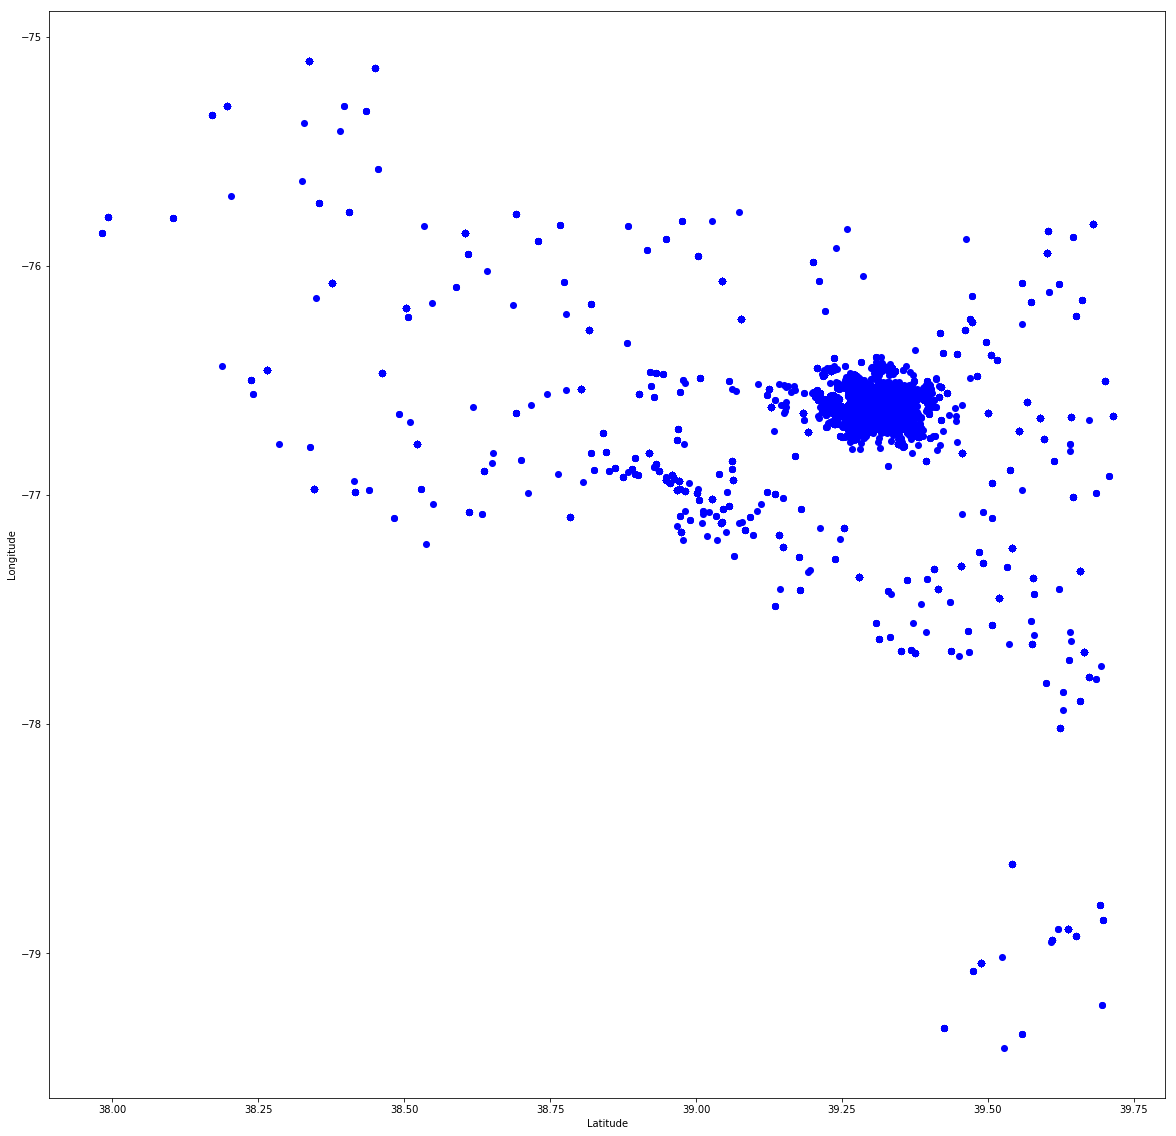

In [127]:
crimePlot= CrimeData.plot.scatter(x='Latitude', y='Longitude', c='blue', s=50, linewidth=0, figsize=(20,20))

In [128]:
#next removing outliers using zscore

CrimeDataNoOutlier= CrimeData
CrimeDataNoOutlier = CrimeDataNoOutlier[np.abs(CrimeDataNoOutlier.Latitude-CrimeDataNoOutlier.Latitude.mean()) 
                                        <= (3*CrimeDataNoOutlier.Latitude.std())]
CrimeDataNoOutlier = CrimeDataNoOutlier[np.abs(CrimeDataNoOutlier.Longitude-CrimeDataNoOutlier.Longitude.mean())
                                        <= (3*CrimeDataNoOutlier.Longitude.std())]

print(len(CrimeDataNoOutlier))

710011


# Plot without outliers by z-score: 

### Removed these because k-means clustering does not work very well with outliers and  noise. However, this ignores approximately 20 thousand crimes. On the other hand, this is not very significant for a sample of 700 thousand +. Still deciding which data set to use for crimes. Liquor dataset was already relatively clean. Not going to bother with removing outliers for liquor dataset.  

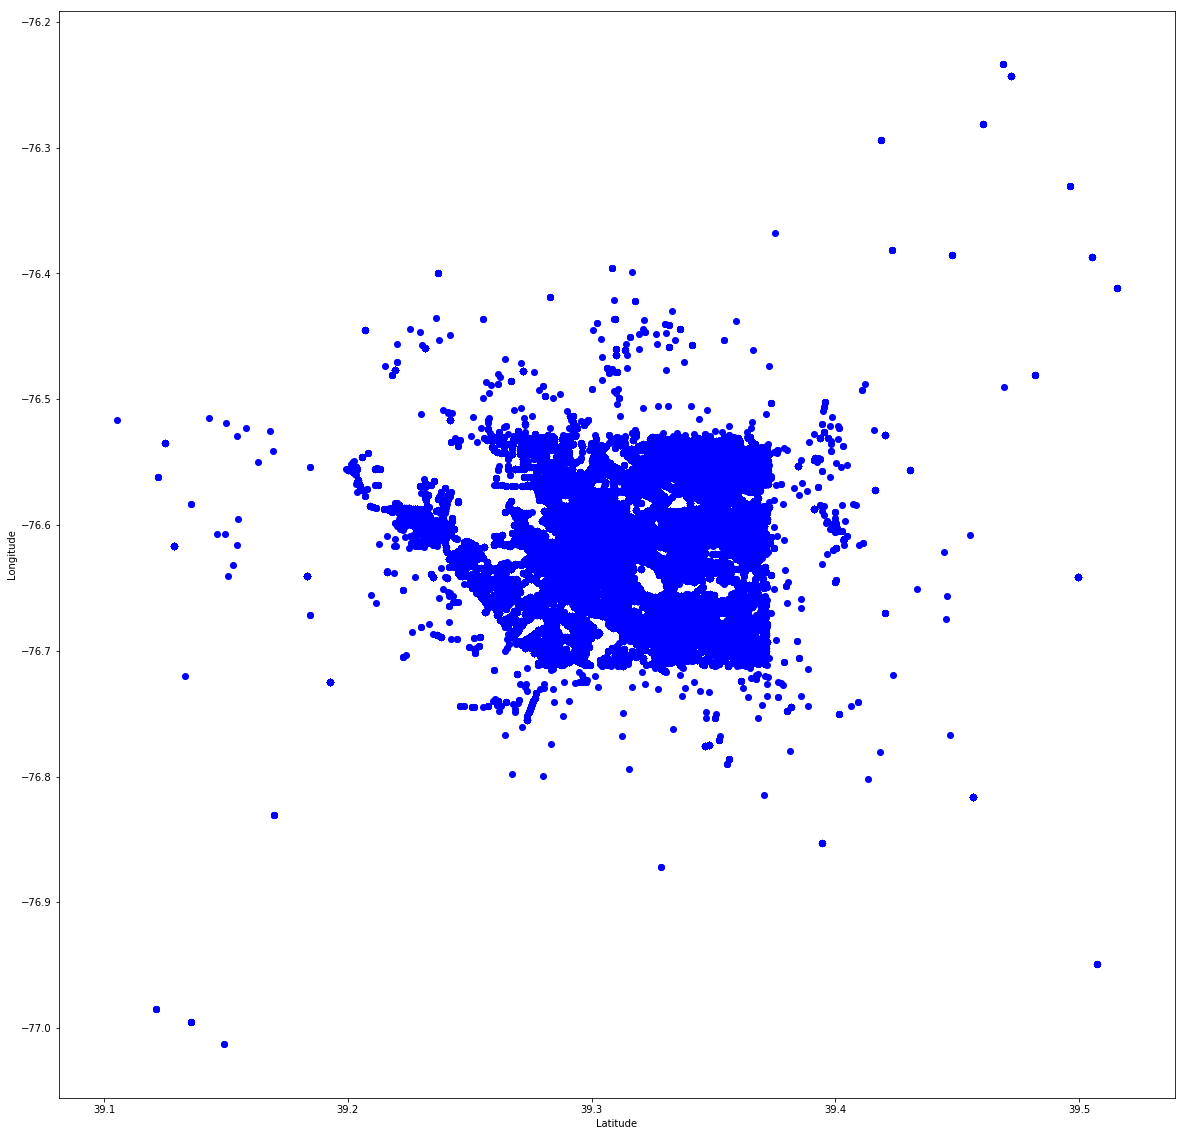

In [129]:
crimeNoOutlier= CrimeDataNoOutlier.plot.scatter(x='Latitude', y='Longitude', c='blue', s=50, linewidth=0, figsize=(20,20))

# Here I am working on creating several datasets.
### This is based on the criteria of type of crime. I am testing if certain kinds of crime cluster closer to liquor.



In [138]:
#all no outlier crime
print(CrimeDataNoOutlier.head())
print("Count of Crimes: "+str(len(CrimeDataNoOutlier)))

   Unnamed: 0  recordId       priority district    description  callNumber  \
0       22291   2899750         Medium       SD       BURGLARY  P172770123   
1       22292   2899621  Non-Emergency       WD      FOLLOW UP  P172763205   
2       22294   2915175            Low       NE    INVESTIGATE  P172821408   
3       22297   2903054         Medium       CD  911/NO  VOICE  P172780681   
4       22299   2915815         Medium       ND     DISORDERLY  P172822136   

        incidentLocation   Latitude  Longitude        date  
0  3400 BLK S HANOVER ST  39.242372 -76.607879  2017-10-04  
1     2400 WINCHESTER ST  39.301589 -76.656323  2017-10-03  
2       5500 SINCLAIR LN  39.325374 -76.537346  2017-10-09  
3   1200 PENNSYLVANIA AV  39.299922 -76.630205  2017-10-05  
4           5900 YORK RD  39.363092 -76.609962  2017-10-09  
Count of Crimes: 710011


In [131]:
disorderlyConduct= CrimeDataNoOutlier[CrimeDataNoOutlier.description   == "DISORDERLY"]

In [132]:
#disorderly conduct
print(disorderlyConduct.head())
print("Count of Disorderly: "+str(len(disorderlyConduct)))

    Unnamed: 0  recordId priority district description  callNumber  \
4        22299   2915815   Medium       ND  DISORDERLY  P172822136   
6        22302   2913779   Medium       CD  DISORDERLY  P172812739   
22       35041   2623633   Medium       NW  DISORDERLY  P171790584   
24       35045   2596149   Medium       SD  DISORDERLY  P171692808   
50       37507   2460888   Medium       NE  DISORDERLY  P171240934   

     incidentLocation   Latitude  Longitude        date  
4        5900 YORK RD  39.363092 -76.609962  2017-10-09  
6     1000 W NORTH AV  39.310433 -76.634847  2017-10-08  
22     3200 CLARKS LN  39.369618 -76.694201  2017-06-28  
24  900 W PATAPSCO AV  39.244843 -76.633181  2017-06-18  
50      700 E 25TH ST  39.318356 -76.603077  2017-05-04  
Count of Disorderly: 71726


In [133]:
autoAccidents = CrimeDataNoOutlier[(CrimeDataNoOutlier.description   == "AUTO ACCIDENT")|
                                   (CrimeDataNoOutlier.description   == "HIT AND RUN")|
                                   (CrimeDataNoOutlier.description   == "AUTO ACC/INJURY")]

In [134]:
#auto accidents including hit and run, auto accident, and auto accidents with injury
print(autoAccidents.head())
print("Count of Auto: "+str(len(autoAccidents)))

    Unnamed: 0  recordId priority district      description  callNumber  \
18       22316   2905088      Low       SD    AUTO ACCIDENT  P172783027   
35       37322   2461946      Low       NW      HIT AND RUN  P171242185   
38       37381   2461366      Low       SE    AUTO ACCIDENT  P171241503   
49       37502   2455357     High       NE  AUTO ACC/INJURY  P171221696   
61       37709   2458903     High       SE  AUTO ACC/INJURY  P171232102   

      incidentLocation   Latitude  Longitude        date  
18     500 WASHBURN AV  39.234508 -76.604280  2017-10-05  
35      2900 WYNHAM RD  39.319507 -76.693700  2017-05-04  
38     400 CORNWALL ST  39.288873 -76.544785  2017-05-04  
49      4300 BERGER AV  39.339553 -76.546932  2017-05-02  
61  300 BLK S PONCA ST  39.287545 -76.554990  2017-05-03  
Count of Auto: 28653


In [135]:
intoxicated = CrimeDataNoOutlier[CrimeDataNoOutlier.description   == "INTOXICATED PERS"]

In [136]:
#intoxicated person
print(intoxicated.head())
print("Count of Intoxicated: "+str(len(intoxicated)))

      Unnamed: 0  recordId priority district       description  callNumber  \
1061       39743   2496123      Low       ND  INTOXICATED PERS  P171362929   
1475       40287   2514681      Low       CD  INTOXICATED PERS  P171422926   
4152       43863   2624315   Medium       ND  INTOXICATED PERS  P171791369   
5559       45695   2672125      Low       ND  INTOXICATED PERS  P171951773   
7611       48351   2769854      Low       CD  INTOXICATED PERS  P172292858   

            incidentLocation   Latitude  Longitude        date  
1061  800 BLK ST DUNSTANS RD  39.360652 -76.603325  2017-05-16  
1475    200 BLK E PRESTON ST  39.304617 -76.613036  2017-05-22  
4152           5700 FALLS RD  39.364660 -76.647363  2017-06-28  
5559     2500 W BELVEDERE AV  39.352908 -76.666818  2017-07-14  
7611             800 PARK AV  39.298487 -76.618455  2017-08-17  
Count of Intoxicated: 1542


In [139]:
assault = CrimeDataNoOutlier[(CrimeDataNoOutlier.description   == "COMMON ASSAULT")|
                             (CrimeDataNoOutlier.description   == "AGGRAV ASSAULT")]

In [140]:
#assault
print(assault.head())
print("Count of Assault: "+str(len(assault)))

    Unnamed: 0  recordId priority district     description  callNumber  \
7        22303   2917762   Medium       SW  COMMON ASSAULT  P172831274   
9        22306   2904600   Medium       SD  COMMON ASSAULT  P172782481   
13       22310   2887559   Medium       CD  COMMON ASSAULT  P172721813   
19       22317   2911311   Medium       CD  COMMON ASSAULT  P172803181   
31       37276   2456157   Medium       SW  COMMON ASSAULT  P171222612   

         incidentLocation   Latitude  Longitude        date  
7      2200 N ELLAMONT ST  39.312165 -76.671115  2017-10-10  
9       2500 SOUTHDENE AV  39.254827 -76.649774  2017-10-05  
13  BALTIMORE PLAZA HOTEL  39.290443 -76.612333  2017-09-29  
19          100 N PACA ST  39.290333 -76.622368  2017-10-07  
31      2600 W FAYETTE ST  39.288819 -76.659100  2017-05-02  
Count of Assault: 39993


In [141]:
propertyDestruction = CrimeDataNoOutlier[CrimeDataNoOutlier.description   == "DESTRUCT PROP"]

In [142]:
#desruction of property
print(propertyDestruction.head())
print("Count of Property Destruction: "+str(len(propertyDestruction)))

     Unnamed: 0  recordId priority district    description  callNumber  \
82        38052   2455285      Low       SD  DESTRUCT PROP  P171221607   
215       38454   2472319      Low       SW  DESTRUCT PROP  P171281418   
230       38477   2471606      Low       ED  DESTRUCT PROP  P171280572   
312       38599   2471668      Low       CD  DESTRUCT PROP  P171280655   
515       38915   2479270      Low       NW  DESTRUCT PROP  P171302742   

                 incidentLocation   Latitude  Longitude        date  
82             600 CHERRY HILL RD  39.250029 -76.622851  2017-05-02  
215          1400 POPLAR GROVE ST  39.303638 -76.665450  2017-05-08  
230  1800 BLK N PATTERSON PARK AV  39.310991 -76.585879  2017-05-08  
312          600 BLK W REDWOOD ST  39.288479 -76.625093  2017-05-08  
515       3500 LIBERTY HEIGHTS AV  39.324532 -76.672625  2017-05-10  
Count of Property Destruction: 12631


In [143]:
narcotics = CrimeDataNoOutlier[(CrimeDataNoOutlier.description   == "NARCOTICSOutside")|
                               (CrimeDataNoOutlier.description   == "NARCOTICS INSIDE")] 

In [144]:
#narcotics
print(narcotics.head())
print("Count of Narcotics: "+str(len(narcotics)))

    Unnamed: 0  recordId priority district       description  callNumber  \
10       22307   2900653   Medium       CD  NARCOTICSOutside  P172771204   
29       37256   2455230   Medium       NW  NARCOTICSOutside  P171221553   
33       37293   2461646   Medium       SW  NARCOTICSOutside  P171241815   
36       37352   2454996   Medium       SD  NARCOTICSOutside  P171221278   
62       37729   2459732   Medium       SW  NARCOTICSOutside  P171233042   

         incidentLocation   Latitude  Longitude        date  
10        2100 MADISON AV  39.309610 -76.635008  2017-10-04  
29  2900 W COLD SPRING LN  39.338102 -76.669925  2017-05-02  
33        3100 W NORTH AV  39.308983 -76.669488  2017-05-04  
36        1500 POPLAND ST  39.229056 -76.589905  2017-05-02  
62        2000 LETITIA AV  39.262213 -76.654219  2017-05-03  
Count of Narcotics: 34278


In [145]:
#all liquor establishments that had a license during the range of dates from 5/1/2017 to 4/30/2018
print(LiquorData.head())
print("Count of Liquor Licenses: "+str(len(LiquorData)))

   Unnamed: 0 LicenseClass SubClass  LicenseNumber LicenseDate LicenseEndDate  \
0        1445            D        B            3.0  2017-05-01     2018-04-30   
1       11619           WD       BW            5.0  2017-05-01     2018-04-30   
2       11683           LB      BWL          179.0  2017-05-01     2018-04-30   
3       11904           LB      BWL          234.0  2017-05-01     2018-04-30   
4       12068           WD       BW           19.0  2017-05-01     2018-04-30   

   LicenseYear  LicenseFee CertificateNumber LicenseStatus    ...      \
0         2017       200.0              0836       Renewed    ...       
1         2017       165.0              0694       Renewed    ...       
2         2017      2000.0              0369       Renewed    ...       
3         2017      1320.0              0603       Renewed    ...       
4         2017       165.0              0852       Renewed    ...       

  EstablishmentDesc DayPerWeek           Description  \
0           Brewer

# Creating Samples for clustering:

### When using the silhouette score metric for checking quality of clusters it was found that samples of 30 thousand entries could be processed in a reasonable amount of time. Therefore, any data sets above this sample size will be randomly sampled without replacement and all data sets will then be saved to csv files. 

In [146]:
crimeSample=CrimeDataNoOutlier.sample(n=30000, random_state=1, replace= False)
narcoticsSample=narcotics.sample(n=30000, random_state=1, replace= False)
assaultSample=assault.sample(n=30000, random_state=1, replace= False)
disorderlySample=disorderlyConduct.sample(n=30000, random_state=1, replace= False)

In [147]:
#saving to csv files every sample dataset (including those that are sufficiently small that no random sampling was employed)
#don't have to save LiquorData as it is already saved to 2017-2018Liquor.csv
crimeSample.to_csv('sample crime.csv')
narcoticsSample.to_csv('sample narcotics.csv')
assaultSample.to_csv('sample assault.csv')
disorderlySample.to_csv('sample disorderly.csv')
autoAccidents.to_csv('sample auto.csv')
intoxicated.to_csv('sample intoxicated.csv')
propertyDestruction.to_csv('sample propertyDestruction.csv')

# Now checking all datasets for clustering and cluster performance metrics. 

##### 1) This is done by looking at sum of squared errors and plotting it to see via elbow method if there is any good k-value. 
##### 2) Afterwards, the quality of the cluster is determined by looking at silhouette score which can also be used to choose best k value.
##### 3) Lastly, clusters are created and plotted based on results of these two metrics. 

## Crime sample: 

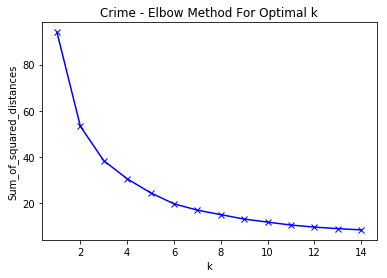

In [148]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(crimeSample[['Latitude', 'Longitude']])
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Crime - Elbow Method For Optimal k')
plt.show()

### Unfortunately when the plot has a smooth curve this is not a good metric for the correct value of k.
### Using silhouette score next gets a k-value of 12 as the best result: 

However, no cluster seems particularly good. A score close to 1 would be much better. Per the quality metrics the crime sample data is not ideal for clustering. 

In [149]:
for n_clusters in range(2, 20):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(crimeSample[['Latitude', 'Longitude']])
    centers = clusterer.cluster_centers_

    score = silhouette_score(crimeSample[['Latitude', 'Longitude']], preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.40587695320278566)
For n_clusters = 3, silhouette score is 0.3610946971771314)
For n_clusters = 4, silhouette score is 0.3790742289410584)
For n_clusters = 5, silhouette score is 0.3683953745595168)
For n_clusters = 6, silhouette score is 0.38193593513672447)
For n_clusters = 7, silhouette score is 0.3919248606007228)
For n_clusters = 8, silhouette score is 0.39895064188341)
For n_clusters = 9, silhouette score is 0.39144539201815054)
For n_clusters = 10, silhouette score is 0.39042128397741915)
For n_clusters = 11, silhouette score is 0.4019108359143875)
For n_clusters = 12, silhouette score is 0.41137938186131295)
For n_clusters = 13, silhouette score is 0.41119707377826614)
For n_clusters = 14, silhouette score is 0.3947626826093805)
For n_clusters = 15, silhouette score is 0.3939346339503891)
For n_clusters = 16, silhouette score is 0.3932851686516951)
For n_clusters = 17, silhouette score is 0.39944107986858046)
For n_clusters = 18, silhou

### Plot of 12 clusters for crime sample.

### Will also print out centroids and counts of items per each cluster. 

In [182]:
# Using sklearn
km = KMeans(n_clusters=12)
km.fit(crimeSample[['Latitude', 'Longitude']])
# Get cluster assignment labels
labels = km.labels_
# Format results as a DataFrame
results = pd.DataFrame([crimeSample[['Latitude', 'Longitude']].index,labels]).T

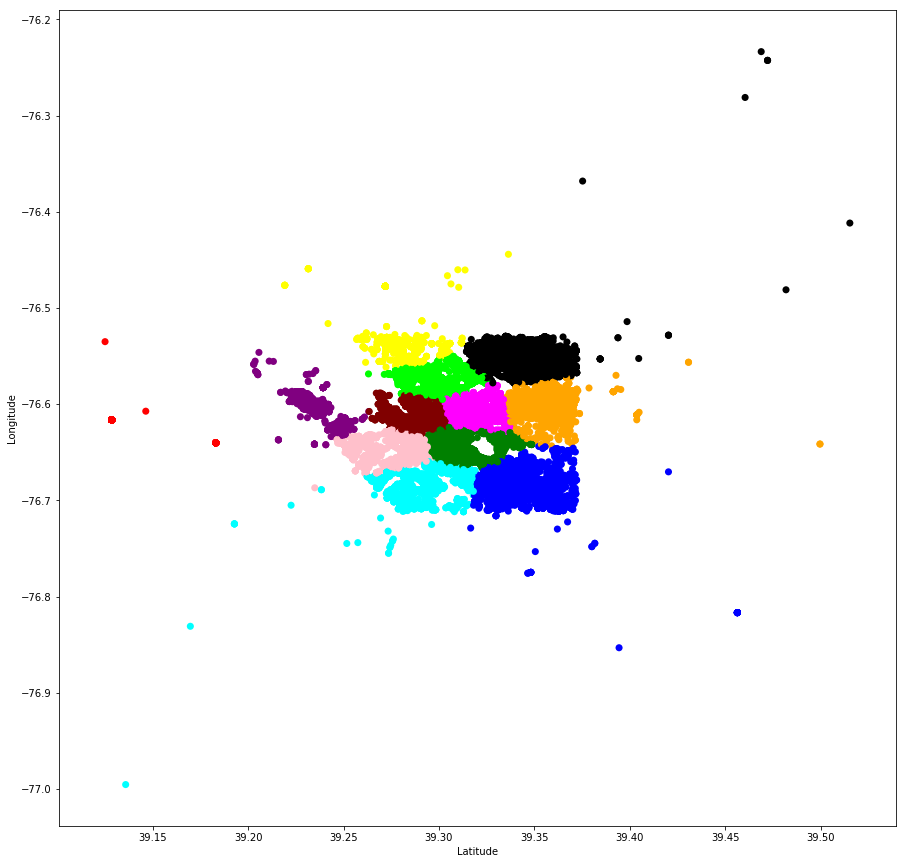

In [156]:
#color based on cluster
res=results[1]
#coloring with 12 colors
#this is the order of colors assigned to cluster values from 0 to 11:
#red, green, yellow, blue, orange, purple, cyan, magenta, lime, pink, black, maroon  
#using this website as color resource https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
col = np.where(res==0,'red',np.where(res==1,'green',np.where(res==2,'yellow',
np.where(res==3,'blue',np.where(res==4,'orange',np.where(res==5,'purple',
np.where(res==6,'cyan',np.where(res==7,'magenta',np.where(res==8,'lime',np.where(res==9,'pink',
np.where(res==10,'black','maroon')))))))))))

crimeSample.plot.scatter(x='Latitude', y='Longitude', c=col, s=50, linewidth=0, figsize=(15,15))

In [157]:
#counter of items per cluster
results[1].value_counts()

8     3992
1     3705
11    3636
3     3495
9     3136
7     2739
6     2527
10    2445
4     1723
5     1361
2     1005
0      236
Name: 1, dtype: int64

In [158]:
crimeCenters = km.cluster_centers_
print(crimeCenters)

[[ 39.14012589 -76.62103076]
 [ 39.3104647  -76.64258548]
 [ 39.28309099 -76.53654291]
 [ 39.34396595 -76.68371847]
 [ 39.35404055 -76.60213238]
 [ 39.23640934 -76.60449943]
 [ 39.29436008 -76.67948747]
 [ 39.31775383 -76.60614753]
 [ 39.29923189 -76.5767193 ]
 [ 39.27860788 -76.64709364]
 [ 39.34025601 -76.55231024]
 [ 39.29020491 -76.61064032]]


#### Interestingly, when we plotted liquor stores based on where in the crime clusters they would be, we did not find any strong correlation of more crime being a predictor of more liquor stores. 
#### The biggest crime cluster which is lime somehow had no liquor stores while the biggest liquor cluster predicted based upon crime clusters is located in the cluster with the second smallest number of crimes. 
#### There seems to be no relation between crime locations and liquor establishments and this may be simply due to transportation and flight affecting the final location of criminals when their misdeeds are called in.
#### It might also be due to the fact that many crimes are unrelated to liquor. We will later try to analyze relationships between some specific kinds of crimes and liquor. 

In [183]:
prediction = km.predict(LiquorData[['Latitude', 'Longitude']])

results2 = pd.DataFrame([LiquorData[['Latitude', 'Longitude']].index,prediction]).T

results2[1].value_counts()

2     728
0     352
7     276
10    165
1     120
4     100
5      94
9      90
11     65
3      48
6      27
Name: 1, dtype: int64

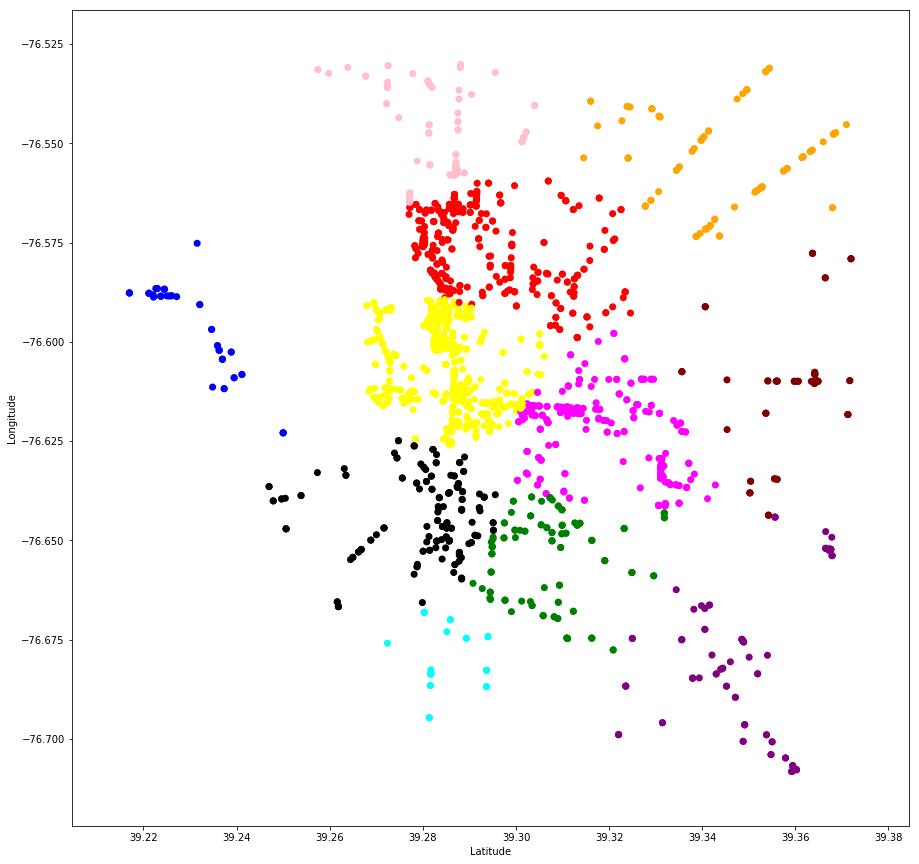

In [184]:
#color based on cluster
res=results2[1]
#coloring with up to 12 colors
#this is the order of colors assigned to cluster values from 0 to 11:
#red, green, yellow, blue, orange, purple, cyan, magenta, lime, pink, black, maroon  
#using this website as color resource https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
col = np.where(res==0,'red',np.where(res==1,'green',np.where(res==2,'yellow',
np.where(res==3,'blue',np.where(res==4,'orange',np.where(res==5,'purple',
np.where(res==6,'cyan',np.where(res==7,'magenta',np.where(res==8,'lime',np.where(res==9,'pink',
np.where(res==10,'black','maroon')))))))))))

LiquorData.plot.scatter(x='Latitude', y='Longitude', c=col, s=50, linewidth=0, figsize=(15,15))

### Just in case I'm looking at crime without its outliers removed. 
### If this does not prove ideal, I will keep using the cleaned data without outliers for every kind of crime sample.
### Here there is an obvious elbow at 4 so a k-value of 4 seems to be good

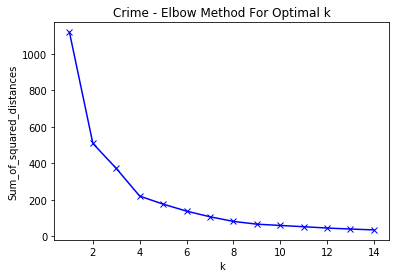

In [166]:
crimeSampleWithOutliers=CrimeData.sample(n=30000, random_state=1, replace= False)

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(crimeSampleWithOutliers[['Latitude', 'Longitude']])
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Crime - Elbow Method For Optimal k')
plt.show()

### Per the silhouette score it seems that while 2 has the best score, 4 clusters are also very good. 
### Per the two metrics we have found that the data with outliers clusters much better and that a k value of 4 is good enough.

In [167]:
for n_clusters in range(2, 20):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(crimeSampleWithOutliers[['Latitude', 'Longitude']])
    centers = clusterer.cluster_centers_

    score = silhouette_score(crimeSampleWithOutliers[['Latitude', 'Longitude']], preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.9407237274680144)
For n_clusters = 3, silhouette score is 0.9070251535329605)
For n_clusters = 4, silhouette score is 0.8964006331232296)
For n_clusters = 5, silhouette score is 0.400988446414236)
For n_clusters = 6, silhouette score is 0.4030434491119555)
For n_clusters = 7, silhouette score is 0.4115646662006836)
For n_clusters = 8, silhouette score is 0.4152800200874047)
For n_clusters = 9, silhouette score is 0.3672920156561492)
For n_clusters = 10, silhouette score is 0.4082384722313588)
For n_clusters = 11, silhouette score is 0.3915188664620265)
For n_clusters = 12, silhouette score is 0.3922757192155159)
For n_clusters = 13, silhouette score is 0.3934854158605026)
For n_clusters = 14, silhouette score is 0.38795906464149615)
For n_clusters = 15, silhouette score is 0.3961406604724207)
For n_clusters = 16, silhouette score is 0.3968896865014012)
For n_clusters = 17, silhouette score is 0.3625830768502397)
For n_clusters = 18, silhouette 

In [168]:
# Using sklearn
km = KMeans(n_clusters=4)
km.fit(crimeSampleWithOutliers[['Latitude', 'Longitude']])
# Get cluster assignment labels
labels = km.labels_
# Format results as a DataFrame
results = pd.DataFrame([crimeSampleWithOutliers[['Latitude', 'Longitude']].index,labels]).T

#counter of items per cluster
results[1].value_counts()

0    29372
2      336
3      192
1      100
Name: 1, dtype: int64

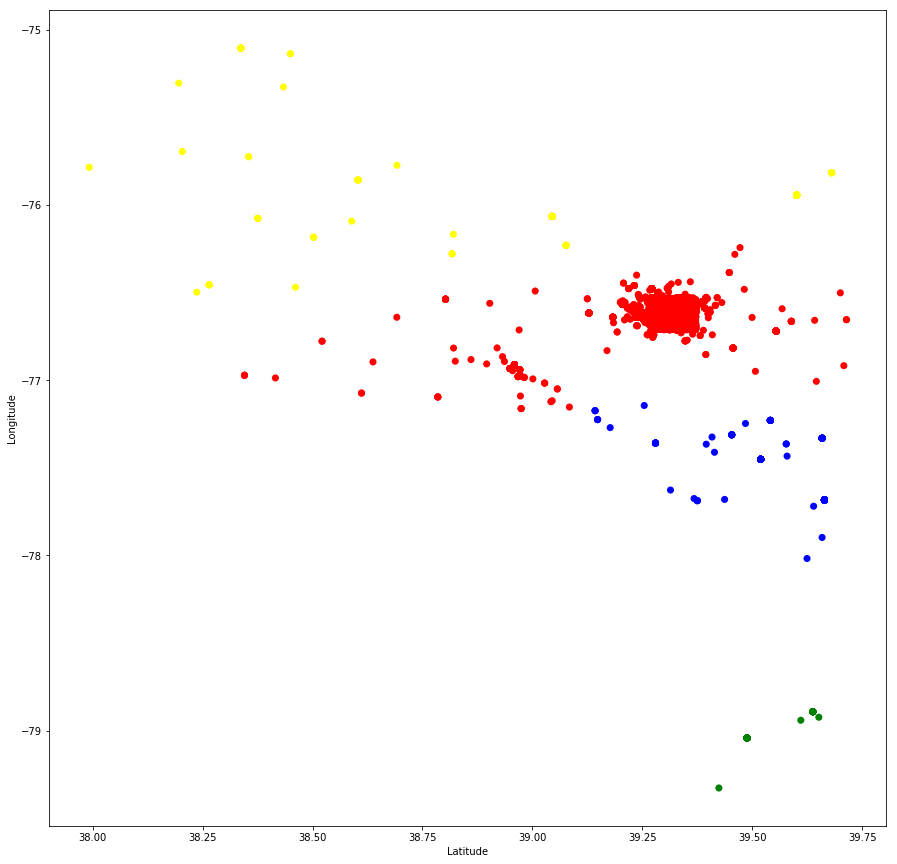

In [169]:
#color based on cluster
res=results[1]
#coloring with up to 12 colors
#this is the order of colors assigned to cluster values from 0 to 11:
#red, green, yellow, blue, orange, purple, cyan, magenta, lime, pink, black, maroon  
#using this website as color resource https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
col = np.where(res==0,'red',np.where(res==1,'green',np.where(res==2,'yellow',
np.where(res==3,'blue',np.where(res==4,'orange',np.where(res==5,'purple',
np.where(res==6,'cyan',np.where(res==7,'magenta',np.where(res==8,'lime',np.where(res==9,'pink',
np.where(res==10,'black','maroon')))))))))))

crimeSampleWithOutliers.plot.scatter(x='Latitude', y='Longitude', c=col, s=50, linewidth=0, figsize=(15,15))

### Unfortunately while this looks good on the surface, it actually doesn't make much sense to use data with outliers. The result creates extremely uneven clusters with 29372/30000 entries in a single cluster and with the other three clusters being given to the few outliers. I will continue to use the outlier/z-score cleaned data since this test for unclean data failed to produce meaningful clusters. 

## Next, Narcotics sample:

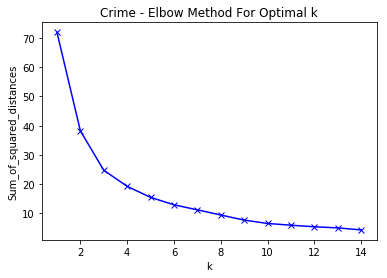

In [170]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(narcoticsSample[['Latitude', 'Longitude']])
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Crime - Elbow Method For Optimal k')
plt.show()

### Unfortunately when the plot has a smooth curve this is not a good metric for the correct value of k. 
### Maybe 3 or 4 is an elbow but not sure. 

### Using silhouette score next confirms 4 is a good value so I shall plot the results of k-means with k=4 

In [171]:
for n_clusters in range(2, 20):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(narcoticsSample[['Latitude', 'Longitude']])
    centers = clusterer.cluster_centers_

    score = silhouette_score(narcoticsSample[['Latitude', 'Longitude']], preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.4868220150975916)
For n_clusters = 3, silhouette score is 0.5034598630318059)
For n_clusters = 4, silhouette score is 0.5391221384190991)
For n_clusters = 5, silhouette score is 0.47159099544827354)
For n_clusters = 6, silhouette score is 0.4651069466420371)
For n_clusters = 7, silhouette score is 0.4700112215184992)
For n_clusters = 8, silhouette score is 0.4769490670015491)
For n_clusters = 9, silhouette score is 0.5007469685711994)
For n_clusters = 10, silhouette score is 0.5106226412312057)
For n_clusters = 11, silhouette score is 0.5018606678225846)
For n_clusters = 12, silhouette score is 0.5002584142981755)
For n_clusters = 13, silhouette score is 0.5067845911707821)
For n_clusters = 14, silhouette score is 0.5086620285632016)
For n_clusters = 15, silhouette score is 0.488721010583168)
For n_clusters = 16, silhouette score is 0.49737370251527946)
For n_clusters = 17, silhouette score is 0.5016348685237753)
For n_clusters = 18, silhouette

In [172]:
# Using sklearn
km = KMeans(n_clusters=4)
km.fit(narcoticsSample[['Latitude', 'Longitude']])
# Get cluster assignment labels
labels = km.labels_
# Format results as a DataFrame
results = pd.DataFrame([narcoticsSample[['Latitude', 'Longitude']].index,labels]).T

#counter of items per cluster
results[1].value_counts()

0    15920
1     7716
2     5289
3     1075
Name: 1, dtype: int64

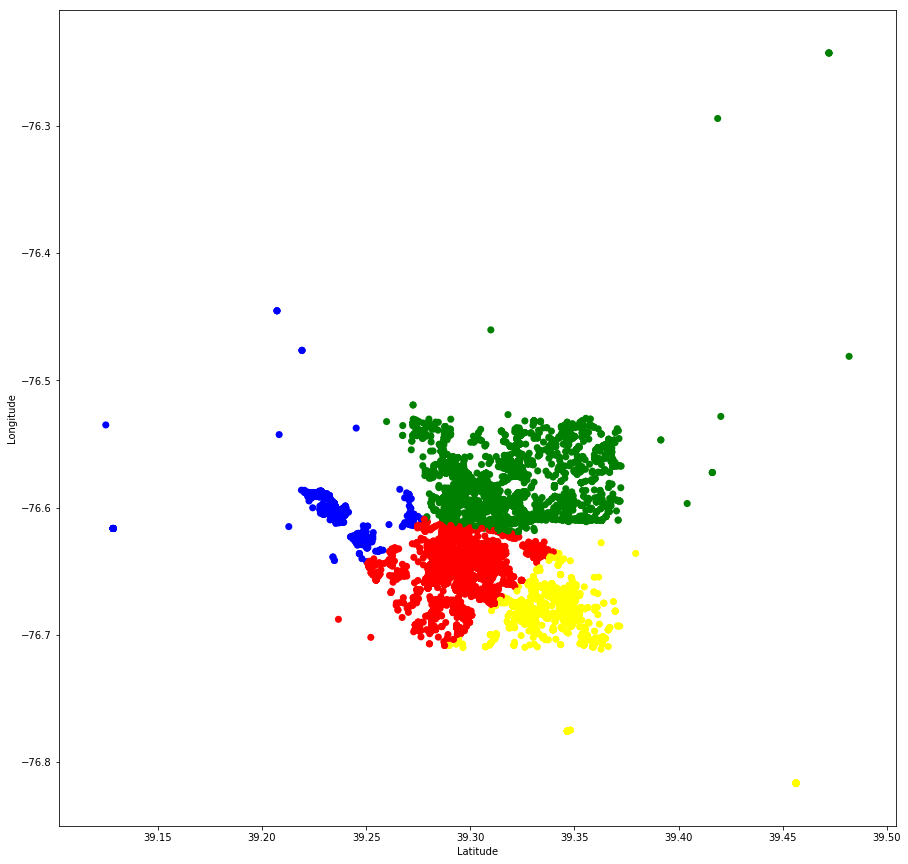

In [175]:
#color based on cluster
res=results[1]
#coloring with up to 12 colors
#this is the order of colors assigned to cluster values from 0 to 11:
#red, green, yellow, blue, orange, purple, cyan, magenta, lime, pink, black, maroon  
#using this website as color resource https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
col = np.where(res==0,'red',np.where(res==1,'green',np.where(res==2,'yellow',
np.where(res==3,'blue',np.where(res==4,'orange',np.where(res==5,'purple',
np.where(res==6,'cyan',np.where(res==7,'magenta',np.where(res==8,'lime',np.where(res==9,'pink',
np.where(res==10,'black','maroon')))))))))))

narcoticsSample.plot.scatter(x='Latitude', y='Longitude', c=col, s=50, linewidth=0, figsize=(15,15))

### As you can see from the following plot which plots liquor establishments by coloring them based on narcotics crime clusters, there is not really any relationship between number of narcotics crimes per cluster and number of liquor establishments per cluster. Narcotics crimes are not a predictor of liquor establishment proximity. 

In [180]:
prediction = km.predict(LiquorData[['Latitude', 'Longitude']])

results2 = pd.DataFrame([LiquorData[['Latitude', 'Longitude']].index,prediction]).T

results2[1].value_counts()

1    1055
0     745
3     147
2     118
Name: 1, dtype: int64

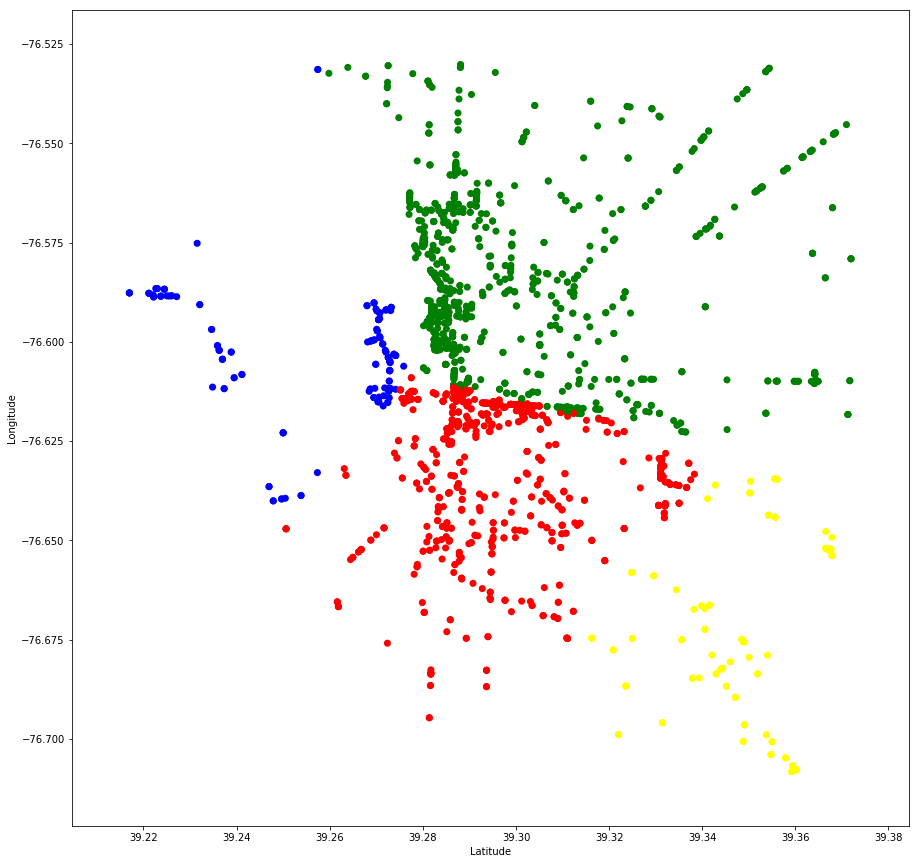

In [181]:
#color based on cluster
res=results2[1]
#coloring with up to 12 colors
#this is the order of colors assigned to cluster values from 0 to 11:
#red, green, yellow, blue, orange, purple, cyan, magenta, lime, pink, black, maroon  
#using this website as color resource https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
col = np.where(res==0,'red',np.where(res==1,'green',np.where(res==2,'yellow',
np.where(res==3,'blue',np.where(res==4,'orange',np.where(res==5,'purple',
np.where(res==6,'cyan',np.where(res==7,'magenta',np.where(res==8,'lime',np.where(res==9,'pink',
np.where(res==10,'black','maroon')))))))))))

LiquorData.plot.scatter(x='Latitude', y='Longitude', c=col, s=50, linewidth=0, figsize=(15,15))

## Assault sample:

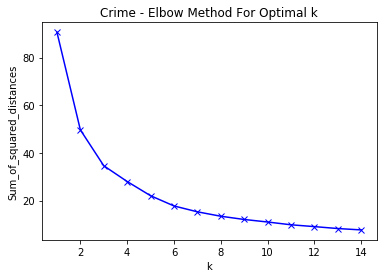

In [185]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(assaultSample[['Latitude', 'Longitude']])
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Crime - Elbow Method For Optimal k')
plt.show()

In [186]:
for n_clusters in range(2, 20):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(assaultSample[['Latitude', 'Longitude']])
    centers = clusterer.cluster_centers_

    score = silhouette_score(assaultSample[['Latitude', 'Longitude']], preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.4123429227593233)
For n_clusters = 3, silhouette score is 0.36575170894595843)
For n_clusters = 4, silhouette score is 0.3847319107078798)
For n_clusters = 5, silhouette score is 0.3947380485265113)
For n_clusters = 6, silhouette score is 0.39091322333744066)
For n_clusters = 7, silhouette score is 0.39995489900835685)
For n_clusters = 8, silhouette score is 0.3861512781154917)
For n_clusters = 9, silhouette score is 0.39044448100909757)
For n_clusters = 10, silhouette score is 0.3954556305390619)
For n_clusters = 11, silhouette score is 0.39511912555694434)
For n_clusters = 12, silhouette score is 0.40025585768709754)
For n_clusters = 13, silhouette score is 0.4111405616488349)
For n_clusters = 14, silhouette score is 0.40931515090730597)
For n_clusters = 15, silhouette score is 0.4018474153816946)
For n_clusters = 16, silhouette score is 0.40625734390134444)
For n_clusters = 17, silhouette score is 0.4081257528837115)
For n_clusters = 18, sil

### Per the two quality metrics, seems like a k value of 2 or 13 is best. Going to use 13 because 2 clusters are not very interesting for our purposes. All clusters don't have particularly good values though. 

### Next plotting the clusters based on said value:

In [214]:
# Using sklearn
km = KMeans(n_clusters=13)
km.fit(assaultSample[['Latitude', 'Longitude']])
# Get cluster assignment labels
labels = km.labels_
# Format results as a DataFrame
results = pd.DataFrame([assaultSample[['Latitude', 'Longitude']].index,labels]).T

#counter of items per cluster
results[1].value_counts()

5     4752
7     3937
6     3782
2     3564
1     2870
0     2322
11    1967
3     1494
10    1441
8     1400
4     1324
12    1106
9       41
Name: 1, dtype: int64

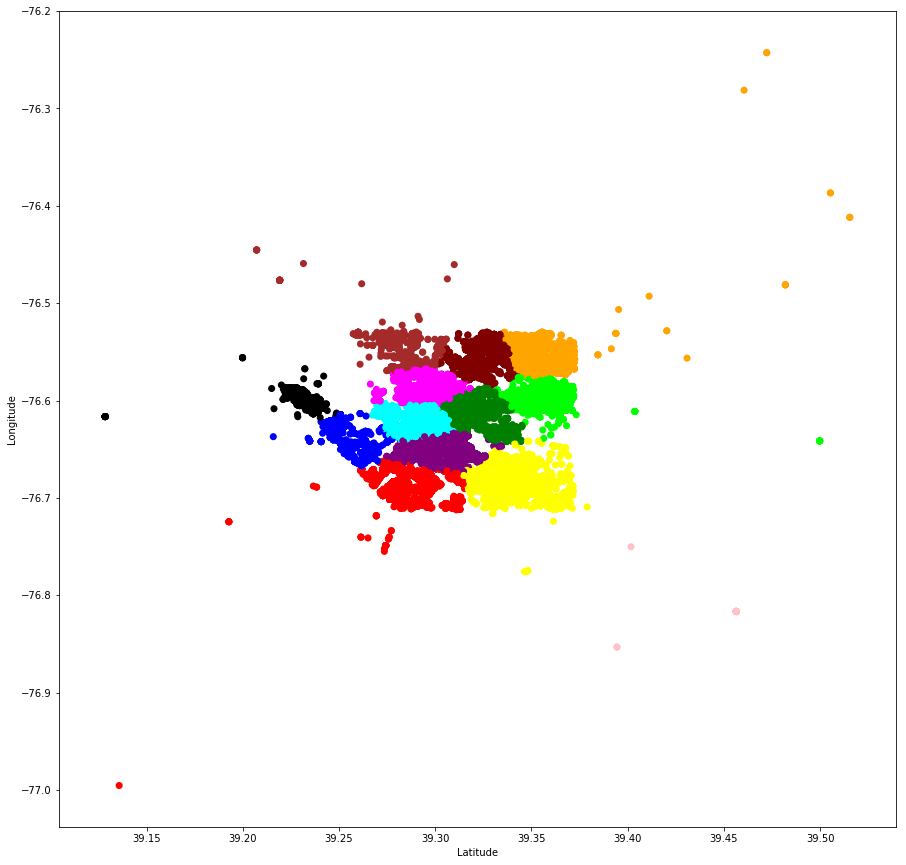

In [215]:
#color based on cluster
res=results[1]
#coloring with up to 13 colors
#this is the order of colors assigned to cluster values from 0 to 11:
#red, green, yellow, blue, orange, purple, cyan, magenta, lime, pink, black, maroon, brown  
#using this website as color resource https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
col = np.where(res==0,'red',np.where(res==1,'green',np.where(res==2,'yellow',
np.where(res==3,'blue',np.where(res==4,'orange',np.where(res==5,'purple',
np.where(res==6,'cyan',np.where(res==7,'magenta',np.where(res==8,'lime',np.where(res==9,'pink',
np.where(res==10,'black',np.where(res==11,'maroon','brown'))))))))))))

assaultSample.plot.scatter(x='Latitude', y='Longitude', c=col, s=50, linewidth=0, figsize=(15,15))

## Next: our first significant relationship between assault crime and liquor:

### Interestingly, this shows the first relationship between crime and liquor. 4 of the top 5 assault crime clusters happen to be the top 4 liquor clusters. These are clusters 6 7 1 and 5. While clusters 6 and 7 have the most liquor with a disproportionate amount each at more than double the amount in any other cluster, cluster 6 which is number 1 for liquor only has the 3rd most crime. However, it's almost tied for 2nd place crime cluster with cluster number 7 which has the 2nd most crime and also happens have the 2nd most liquor. Other factors obviously come into play such as the relative safety of neighborhoods but when the top 4 liquor districts have 1503/2065 liquor licenses or 72.78 % and also 15341/30000 of assault crimes from the sample meaning 51.14 % there is some correlation, especially when there are 13 clusters and such a majority of assault crimes is significant. Thus, one can say assault can be somewhat predicted by liquor licenses. Finding the actual relationship would involve mathematics beyond the scope of this course (perhaps some form of regression would work but spatial data does not lend itself to linear regression and other regression algorithms are beyond our scope). Furthermore, the clusters themselves are not high quality as per the metrics so it's difficult to say whether the results are accurate. Further research beyond the scope of this course would be necessary. 


In [216]:
prediction = km.predict(LiquorData[['Latitude', 'Longitude']])

results2 = pd.DataFrame([LiquorData[['Latitude', 'Longitude']].index,prediction]).T

results2[1].value_counts()

6     547
7     532
1     225
5     199
12    161
2     104
11     62
4      60
8      59
10     45
3      38
0      33
Name: 1, dtype: int64

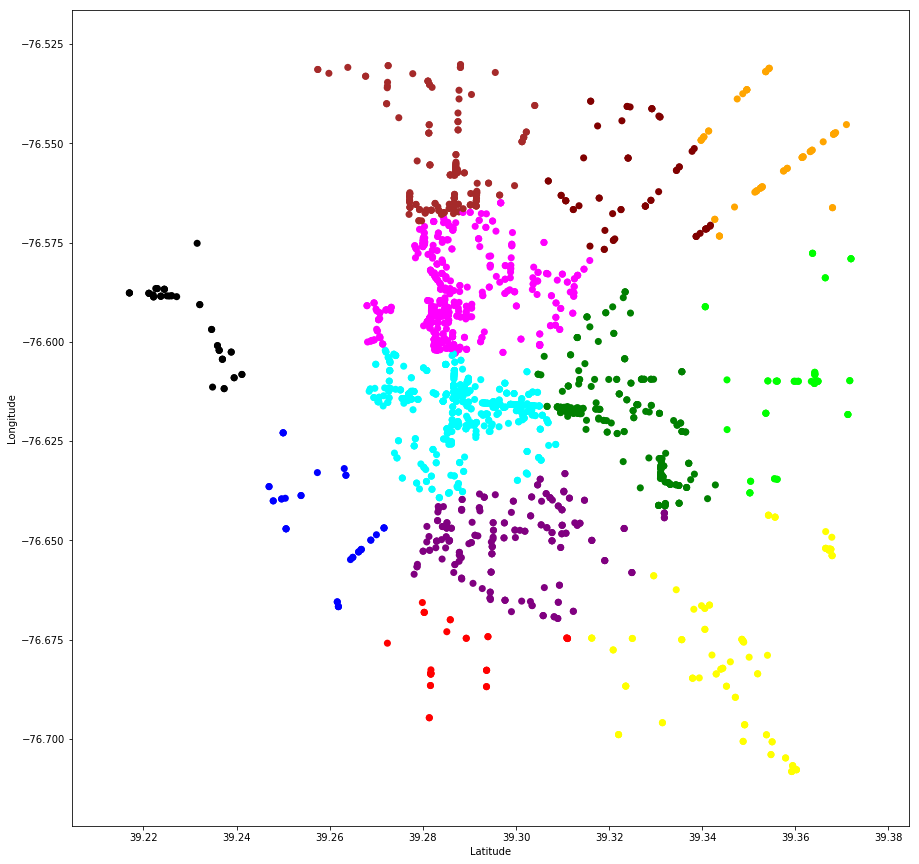

In [217]:
#color based on cluster
res=results2[1]
#coloring with up to 13 colors
#this is the order of colors assigned to cluster values from 0 to 11:
#red, green, yellow, blue, orange, purple, cyan, magenta, lime, pink, black, maroon, brown  
#using this website as color resource https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
col = np.where(res==0,'red',np.where(res==1,'green',np.where(res==2,'yellow',
np.where(res==3,'blue',np.where(res==4,'orange',np.where(res==5,'purple',
np.where(res==6,'cyan',np.where(res==7,'magenta',np.where(res==8,'lime',np.where(res==9,'pink',
np.where(res==10,'black',np.where(res==11,'maroon','brown'))))))))))))

LiquorData.plot.scatter(x='Latitude', y='Longitude', c=col, s=50, linewidth=0, figsize=(15,15))

## Disorderly Sample:

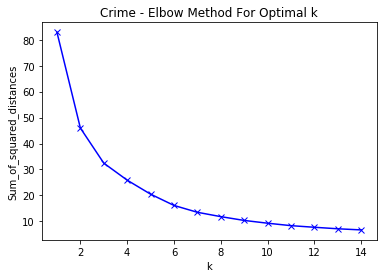

In [191]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(disorderlySample[['Latitude', 'Longitude']])
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Crime - Elbow Method For Optimal k')
plt.show()

In [192]:
for n_clusters in range(2, 20):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(disorderlySample[['Latitude', 'Longitude']])
    centers = clusterer.cluster_centers_

    score = silhouette_score(disorderlySample[['Latitude', 'Longitude']], preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.39727105434379956)
For n_clusters = 3, silhouette score is 0.35820137668051644)
For n_clusters = 4, silhouette score is 0.3568196468667656)
For n_clusters = 5, silhouette score is 0.37333899484752125)
For n_clusters = 6, silhouette score is 0.3969022870528776)
For n_clusters = 7, silhouette score is 0.40358325374114035)
For n_clusters = 8, silhouette score is 0.3935469758497626)
For n_clusters = 9, silhouette score is 0.4120576443259337)
For n_clusters = 10, silhouette score is 0.427594062922722)
For n_clusters = 11, silhouette score is 0.4299119632792644)
For n_clusters = 12, silhouette score is 0.42910141717657224)
For n_clusters = 13, silhouette score is 0.4315669826447082)
For n_clusters = 14, silhouette score is 0.4122275747655188)
For n_clusters = 15, silhouette score is 0.42090394751059684)
For n_clusters = 16, silhouette score is 0.4132284560679133)
For n_clusters = 17, silhouette score is 0.40946497629751055)
For n_clusters = 18, silho

### Per the two quality metrics, no real elbow and seems like a k value of 13 is best.  However, all clusters don't have particularly good values. 

### Next plotting the clusters based on said value:

In [210]:
# Using sklearn
km = KMeans(n_clusters=13)
km.fit(disorderlySample[['Latitude', 'Longitude']])
# Get cluster assignment labels
labels = km.labels_
# Format results as a DataFrame
results = pd.DataFrame([disorderlySample[['Latitude', 'Longitude']].index,labels]).T

#counter of items per cluster
results[1].value_counts()

0     4409
6     3440
11    3380
4     3292
7     3009
12    2384
2     2091
1     2045
9     1905
3     1489
5     1429
8     1105
10      22
Name: 1, dtype: int64

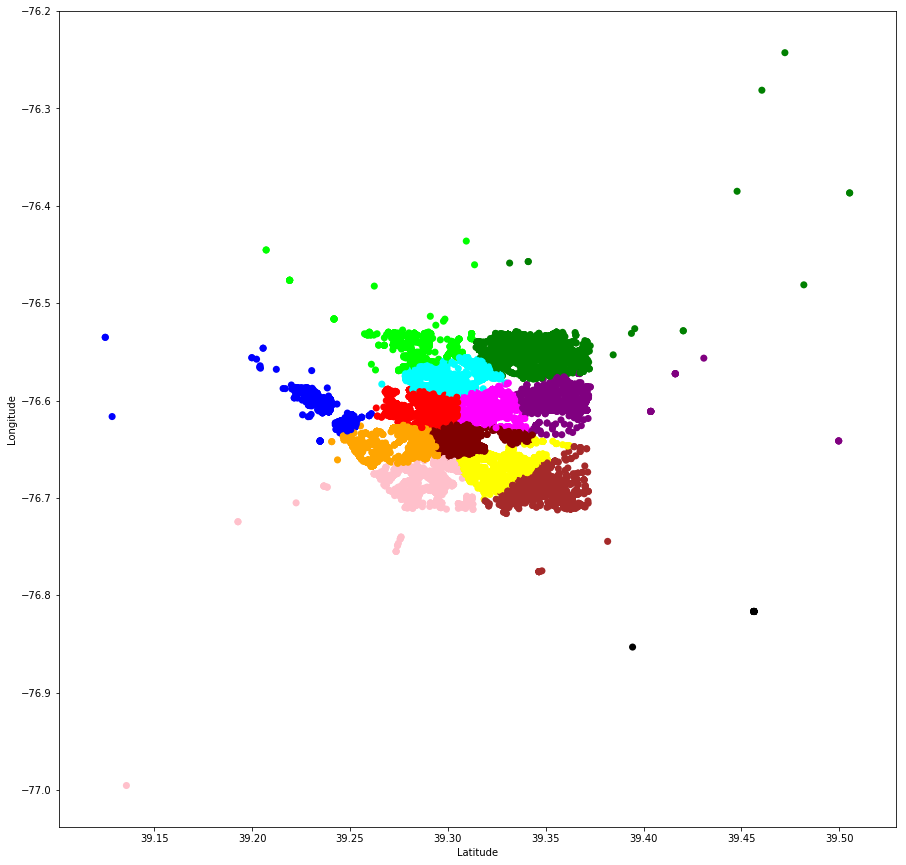

In [211]:
#color based on cluster
res=results[1]
#coloring with up to 12 colors
#this is the order of colors assigned to cluster values from 0 to 11:
#red, green, yellow, blue, orange, purple, cyan, magenta, lime, pink, black, maroon, brown  
#using this website as color resource https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
col = np.where(res==0,'red',np.where(res==1,'green',np.where(res==2,'yellow',
np.where(res==3,'blue',np.where(res==4,'orange',np.where(res==5,'purple',
np.where(res==6,'cyan',np.where(res==7,'magenta',np.where(res==8,'lime',np.where(res==9,'pink',
np.where(res==10,'black',np.where(res==11,'maroon','brown'))))))))))))

disorderlySample.plot.scatter(x='Latitude', y='Longitude', c=col, s=50, linewidth=0, figsize=(15,15))

## Next: Prediction based on disorderly conduct crime and liquor districts: 

In [212]:
prediction = km.predict(LiquorData[['Latitude', 'Longitude']])

results2 = pd.DataFrame([LiquorData[['Latitude', 'Longitude']].index,prediction]).T

results2[1].value_counts()

0     749
6     310
7     173
11    172
4     166
8     116
1     100
12     74
5      59
2      52
3      48
9      46
Name: 1, dtype: int64

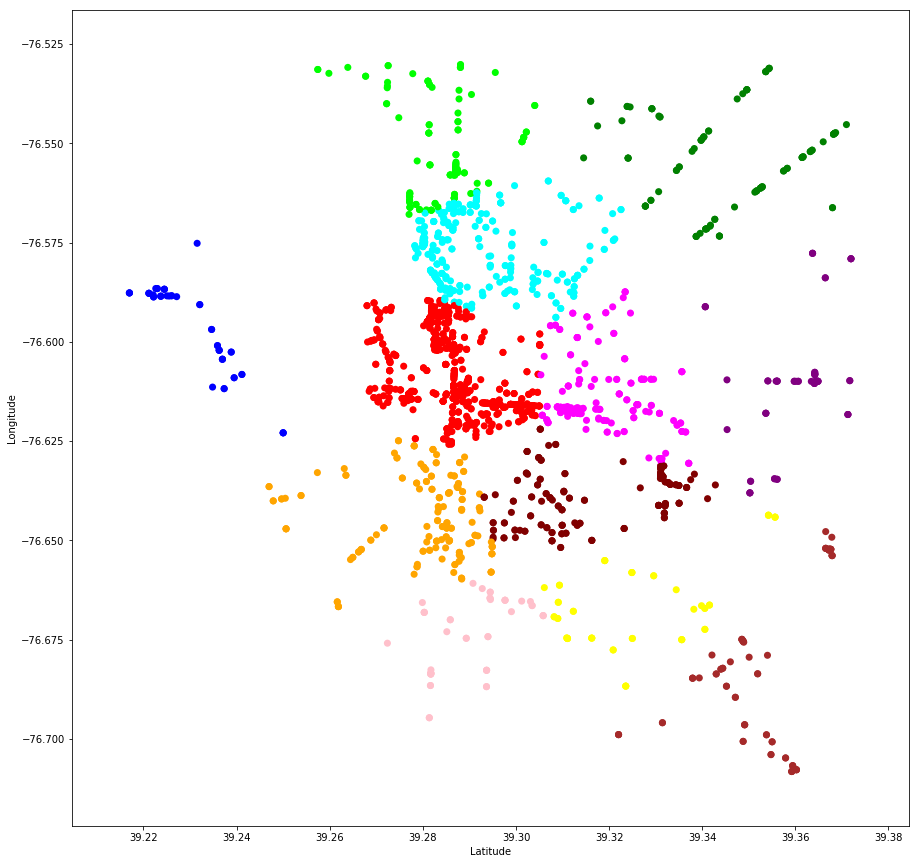

In [213]:
#color based on cluster
res=results2[1]
#coloring with up to 13 colors
#this is the order of colors assigned to cluster values from 0 to 11:
#red, green, yellow, blue, orange, purple, cyan, magenta, lime, pink, black, maroon, brown  
#using this website as color resource https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
col = np.where(res==0,'red',np.where(res==1,'green',np.where(res==2,'yellow',
np.where(res==3,'blue',np.where(res==4,'orange',np.where(res==5,'purple',
np.where(res==6,'cyan',np.where(res==7,'magenta',np.where(res==8,'lime',np.where(res==9,'pink',
np.where(res==10,'black',np.where(res==11,'maroon','brown'))))))))))))

LiquorData.plot.scatter(x='Latitude', y='Longitude', c=col, s=50, linewidth=0, figsize=(15,15))

### This time around, the relationship between disorderly conduct and liquor is potentially even closer.  Once again 4 of the 5 highest crime clusters correlate to 4 of the highest liquor clusters. However, this time the number one crime and liquor district line up as do the number two crime and liquor districts. Here the relationship may thus be slightly closer though once again regression would be a better metric to make certain of that. These clusters only work to categorize that liquor and disorderly conduct crimes tend to bunch together. The clusters in question are 0, 6, 7, and 11. They make up 14238/30000 = 47.46 percent of crime and 1404/ 2065 liquor licenses = 67.99 percent. Once again we must mention that the data is not ideal for clustering and the clusters are mildly questionnable due to a poor sillhoute coefficient as well as the visuals which indicate not the most distinct clusters. K-means algorithms are ideal for similarly sized clusters of data with round shapes and distinct separation. We are working with imperfect data which was cleaned as best as we could and our conclusions may be erroneous. 

## Auto Accidents:

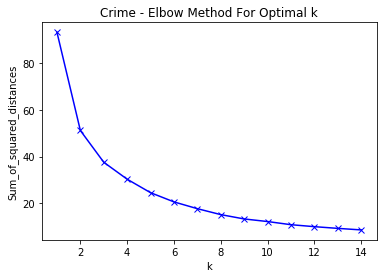

In [201]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(autoAccidents[['Latitude', 'Longitude']])
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Crime - Elbow Method For Optimal k')
plt.show()

In [202]:
for n_clusters in range(2, 20):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(autoAccidents[['Latitude', 'Longitude']])
    centers = clusterer.cluster_centers_

    score = silhouette_score(autoAccidents[['Latitude', 'Longitude']], preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.4035248961101017)
For n_clusters = 3, silhouette score is 0.351300087572338)
For n_clusters = 4, silhouette score is 0.3608646907434382)
For n_clusters = 5, silhouette score is 0.3572885554557207)
For n_clusters = 6, silhouette score is 0.3661726345522411)
For n_clusters = 7, silhouette score is 0.3895100020800064)
For n_clusters = 8, silhouette score is 0.39508403021174615)
For n_clusters = 9, silhouette score is 0.39126821558965713)
For n_clusters = 10, silhouette score is 0.38945754052089954)
For n_clusters = 11, silhouette score is 0.3856414912743189)
For n_clusters = 12, silhouette score is 0.3825244290045391)
For n_clusters = 13, silhouette score is 0.3788299150825312)
For n_clusters = 14, silhouette score is 0.3856111519281753)
For n_clusters = 15, silhouette score is 0.37990914765838996)
For n_clusters = 16, silhouette score is 0.3875398730463252)
For n_clusters = 17, silhouette score is 0.39214102963725234)
For n_clusters = 18, silhoue

### Per the two quality metrics, no real elbow except maybe 2 and seems like a k value of 2 or 8 is best.  However, all clusters don't have particularly good values. Using 8 though it is second best because more clusters are more interesting and useful for us rather than just two clusters. 

### Next plotting the clusters based on said value:

In [203]:
# Using sklearn
km = KMeans(n_clusters=8)
km.fit(autoAccidents[['Latitude', 'Longitude']])
# Get cluster assignment labels
labels = km.labels_
# Format results as a DataFrame
results = pd.DataFrame([autoAccidents[['Latitude', 'Longitude']].index,labels]).T

#counter of items per cluster
results[1].value_counts()

2    6966
1    5671
7    4362
4    3512
3    3509
0    3074
5    1451
6     108
Name: 1, dtype: int64

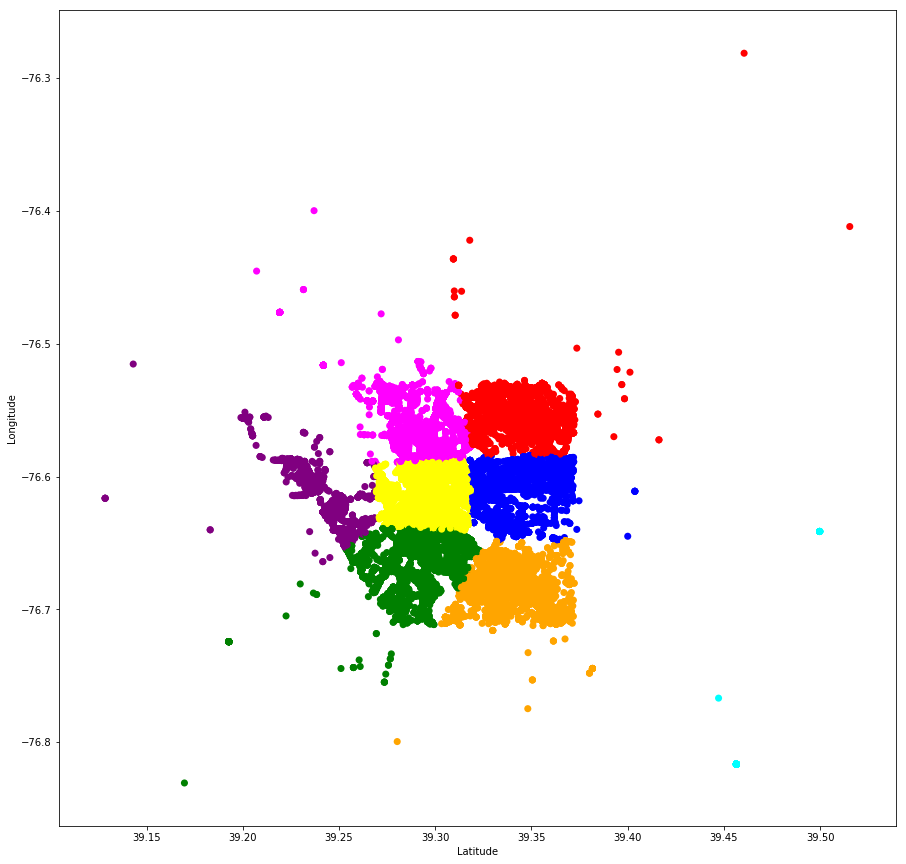

In [204]:
#color based on cluster
res=results[1]
#coloring with up to 12 colors
#this is the order of colors assigned to cluster values from 0 to 11:
#red, green, yellow, blue, orange, purple, cyan, magenta, lime, pink, black, maroon, brown  
#using this website as color resource https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
col = np.where(res==0,'red',np.where(res==1,'green',np.where(res==2,'yellow',
np.where(res==3,'blue',np.where(res==4,'orange',np.where(res==5,'purple',
np.where(res==6,'cyan',np.where(res==7,'magenta',np.where(res==8,'lime',np.where(res==9,'pink',
np.where(res==10,'black',np.where(res==11,'maroon','brown'))))))))))))

autoAccidents.plot.scatter(x='Latitude', y='Longitude', c=col, s=50, linewidth=0, figsize=(15,15))

## Next: Prediction based on auto accident crime and liquor districts: 

In [205]:
prediction = km.predict(LiquorData[['Latitude', 'Longitude']])

results2 = pd.DataFrame([LiquorData[['Latitude', 'Longitude']].index,prediction]).T

results2[1].value_counts()

2    946
7    398
1    223
3    212
0    116
4    100
5     70
Name: 1, dtype: int64

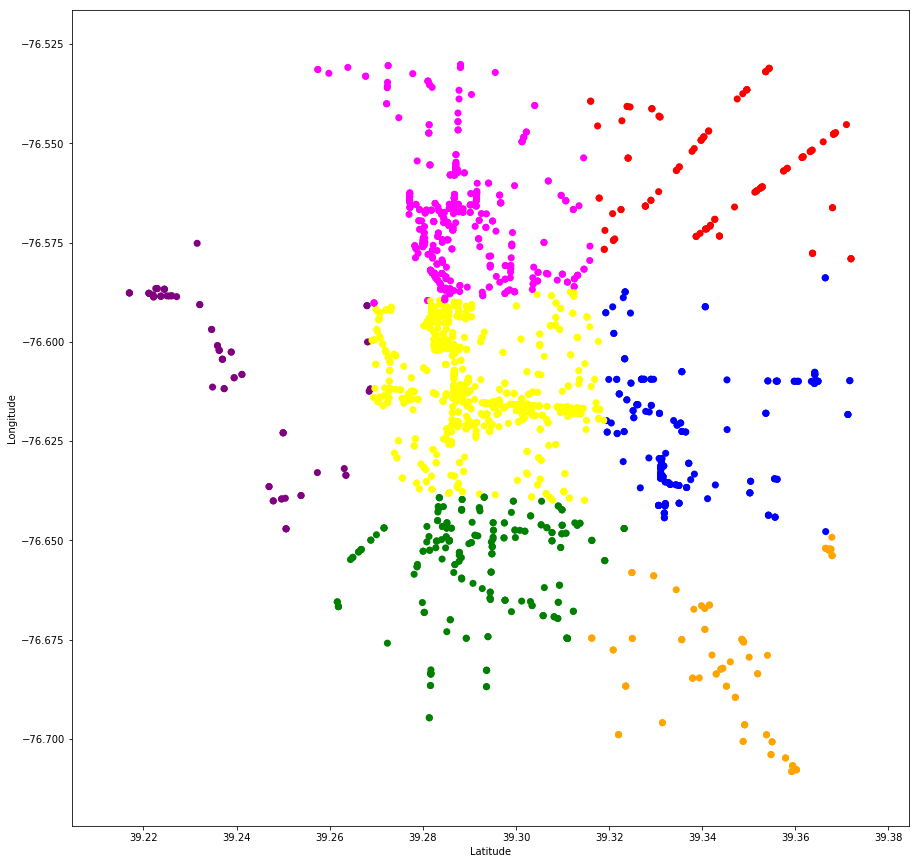

In [206]:
#color based on cluster
res=results2[1]
#coloring with up to 13 colors
#this is the order of colors assigned to cluster values from 0 to 11:
#red, green, yellow, blue, orange, purple, cyan, magenta, lime, pink, black, maroon, brown  
#using this website as color resource https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
col = np.where(res==0,'red',np.where(res==1,'green',np.where(res==2,'yellow',
np.where(res==3,'blue',np.where(res==4,'orange',np.where(res==5,'purple',
np.where(res==6,'cyan',np.where(res==7,'magenta',np.where(res==8,'lime',np.where(res==9,'pink',
np.where(res==10,'black',np.where(res==11,'maroon','brown'))))))))))))

LiquorData.plot.scatter(x='Latitude', y='Longitude', c=col, s=50, linewidth=0, figsize=(15,15))

### Also good correlation between automotive accidents and liquor licenses. Top 3 out of 8 liquor and crime districts are the same. 1567/2065 = 75.88 percent of liquor licenses while 16999/ 28653 = 59.32 percent of crime. Here a majority not a plurality of this auto accident crime exists in the top/majority liquor districts. This is the closest correlation as of yet at least within our limited non regression means of determining such things. This makes sense as alcohol and auto accidents whould be closely related. 


## Data for intoxicated crimes. Presumably this is public intoxication of a sufficient degree as to be criminal: 

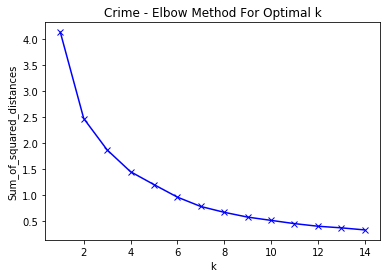

In [207]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(intoxicated[['Latitude', 'Longitude']])
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Crime - Elbow Method For Optimal k')
plt.show()

In [208]:
for n_clusters in range(2, 20):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(intoxicated[['Latitude', 'Longitude']])
    centers = clusterer.cluster_centers_

    score = silhouette_score(intoxicated[['Latitude', 'Longitude']], preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.3712789927533821)
For n_clusters = 3, silhouette score is 0.3458253399034804)
For n_clusters = 4, silhouette score is 0.35575977908256606)
For n_clusters = 5, silhouette score is 0.3747043780243541)
For n_clusters = 6, silhouette score is 0.39163649314990195)
For n_clusters = 7, silhouette score is 0.423776402888947)
For n_clusters = 8, silhouette score is 0.4263689914307622)
For n_clusters = 9, silhouette score is 0.4112002574730293)
For n_clusters = 10, silhouette score is 0.4103792714302113)
For n_clusters = 11, silhouette score is 0.4111284987547683)
For n_clusters = 12, silhouette score is 0.4252182223243004)
For n_clusters = 13, silhouette score is 0.43040413399756683)
For n_clusters = 14, silhouette score is 0.4349114015656159)
For n_clusters = 15, silhouette score is 0.42254737067491277)
For n_clusters = 16, silhouette score is 0.44499649576737743)
For n_clusters = 17, silhouette score is 0.42801711149936966)
For n_clusters = 18, silhou

### Seems like 16 clusters are best. No elbow.

### Plotting next: 

In [219]:
# Using sklearn
km = KMeans(n_clusters=16)
km.fit(intoxicated[['Latitude', 'Longitude']])
# Get cluster assignment labels
labels = km.labels_
# Format results as a DataFrame
results = pd.DataFrame([intoxicated[['Latitude', 'Longitude']].index,labels]).T

#counter of items per cluster
results[1].value_counts()

12    191
7     184
1     181
9     177
3     134
13    122
5     107
14     82
4      78
0      72
6      61
11     56
2      55
10     39
15      2
8       1
Name: 1, dtype: int64

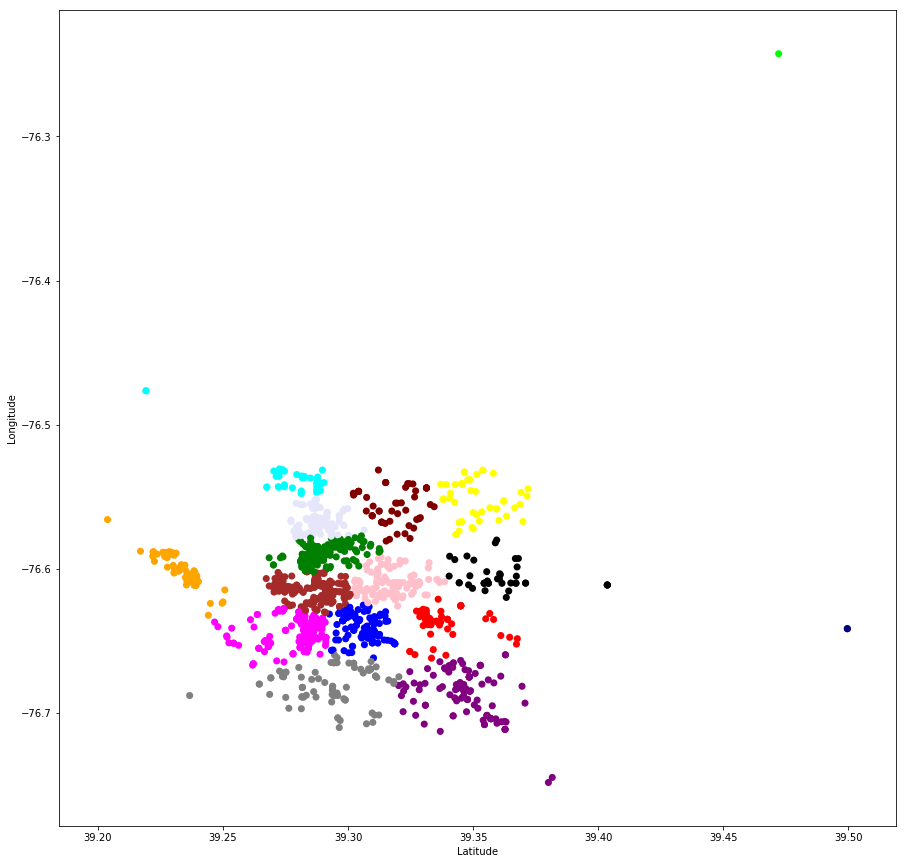

In [221]:
#color based on cluster
res=results[1]
#coloring with up to 16 colors
#this is the order of colors assigned to cluster values from 0 to 15:
#red, green, yellow, blue, orange, purple, cyan, magenta, lime, pink, black, maroon, brown, lavender, grey, navy 
#using this website as color resource https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
col = np.where(res==0,'red',np.where(res==1,'green',np.where(res==2,'yellow',
    np.where(res==3,'blue',np.where(res==4,'orange',np.where(res==5,'purple',
    np.where(res==6,'cyan',np.where(res==7,'magenta',np.where(res==8,'lime',np.where(res==9,'pink',
    np.where(res==10,'black',np.where(res==11,'maroon',np.where(res==12,'brown',np.where(res==13,'lavender',
    np.where(res==14,'grey','navy')))))))))))))))

intoxicated.plot.scatter(x='Latitude', y='Longitude', c=col, s=50, linewidth=0, figsize=(15,15))

### Liquor clustering/prediction based on intoxication crimes next:

In [222]:
prediction = km.predict(LiquorData[['Latitude', 'Longitude']])

results2 = pd.DataFrame([LiquorData[['Latitude', 'Longitude']].index,prediction]).T

results2[1].value_counts()

12    474
1     391
13    213
9     188
7     145
0     136
3     112
5      73
2      72
11     63
14     62
10     49
4      48
6      39
Name: 1, dtype: int64

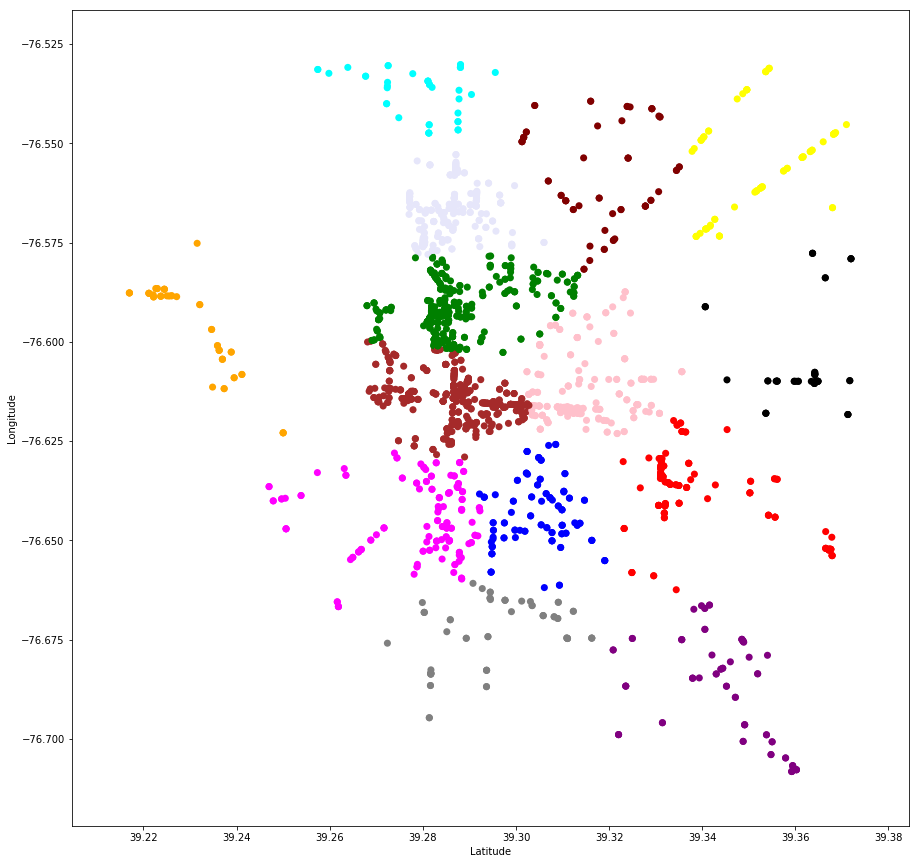

In [223]:
#color based on cluster
res=results2[1]
#coloring with up to 16 colors
#this is the order of colors assigned to cluster values from 0 to 15:
#red, green, yellow, blue, orange, purple, cyan, magenta, lime, pink, black, maroon, brown, lavender, grey, navy
#using this website as color resource https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
col = np.where(res==0,'red',np.where(res==1,'green',np.where(res==2,'yellow',
    np.where(res==3,'blue',np.where(res==4,'orange',np.where(res==5,'purple',
    np.where(res==6,'cyan',np.where(res==7,'magenta',np.where(res==8,'lime',np.where(res==9,'pink',
    np.where(res==10,'black',np.where(res==11,'maroon',np.where(res==12,'brown',np.where(res==13,'lavender',
    np.where(res==14,'grey','navy')))))))))))))))

LiquorData.plot.scatter(x='Latitude', y='Longitude', c=col, s=50, linewidth=0, figsize=(15,15))

### Top 5 liquor at clusters 12, 1, 13, 9, 7 had 5 out of top 6 crimes with 1411/2065 = 68.33 percent of liquor. Order of crimes was 12, 7, 1, 9, 3, 13 with 855/1542 = 55.45 percent of crimes. Again predictably, proximity to many liquor establishments in a district was correlated to many crimes of intoxication. The number one intoxication crime and liquor district was the same with the 12th cluster being represented. However, outside of that, the order of these clusters is rather off so perhaps the relationship is not the strongest of the ones we've looked at but still very significant with a majority of high intoxication crime clusters also holding the majority of liquor licensed establishments. 

## Property Destruction: 

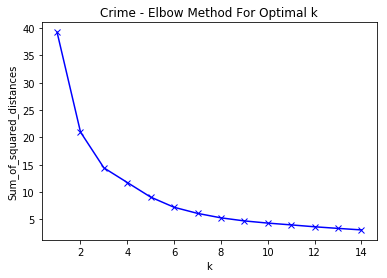

In [224]:
#perhaps elbow at 2 or 3. not sure but not really. Looks more like smooth curve.

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(propertyDestruction[['Latitude', 'Longitude']])
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Crime - Elbow Method For Optimal k')
plt.show()

In [226]:
for n_clusters in range(2, 30):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(propertyDestruction[['Latitude', 'Longitude']])
    centers = clusterer.cluster_centers_

    score = silhouette_score(propertyDestruction[['Latitude', 'Longitude']], preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.41856771053795205)
For n_clusters = 3, silhouette score is 0.3708917623314383)
For n_clusters = 4, silhouette score is 0.3614105858503151)
For n_clusters = 5, silhouette score is 0.3903291726420873)
For n_clusters = 6, silhouette score is 0.38623869788421483)
For n_clusters = 7, silhouette score is 0.404387163006873)
For n_clusters = 8, silhouette score is 0.39031422210471134)
For n_clusters = 9, silhouette score is 0.39294456589748245)
For n_clusters = 10, silhouette score is 0.39278838461142107)
For n_clusters = 11, silhouette score is 0.3965006201523568)
For n_clusters = 12, silhouette score is 0.3935487724219734)
For n_clusters = 13, silhouette score is 0.39530828528895867)
For n_clusters = 14, silhouette score is 0.3995962811155992)
For n_clusters = 15, silhouette score is 0.4001580872692324)
For n_clusters = 16, silhouette score is 0.40132271614486115)
For n_clusters = 17, silhouette score is 0.4027174894737467)
For n_clusters = 18, silho

### 2 clusters is much better silhouette score but 7 is the next best thing and more useful for our analysis. 

### Therefore, plotting 7 clusters: 

In [227]:
# Using sklearn
km = KMeans(n_clusters=7)
km.fit(propertyDestruction[['Latitude', 'Longitude']])
# Get cluster assignment labels
labels = km.labels_
# Format results as a DataFrame
results = pd.DataFrame([propertyDestruction[['Latitude', 'Longitude']].index,labels]).T

#counter of items per cluster
results[1].value_counts()

5    2699
4    2402
1    1881
6    1601
3    1591
2    1377
0    1080
Name: 1, dtype: int64

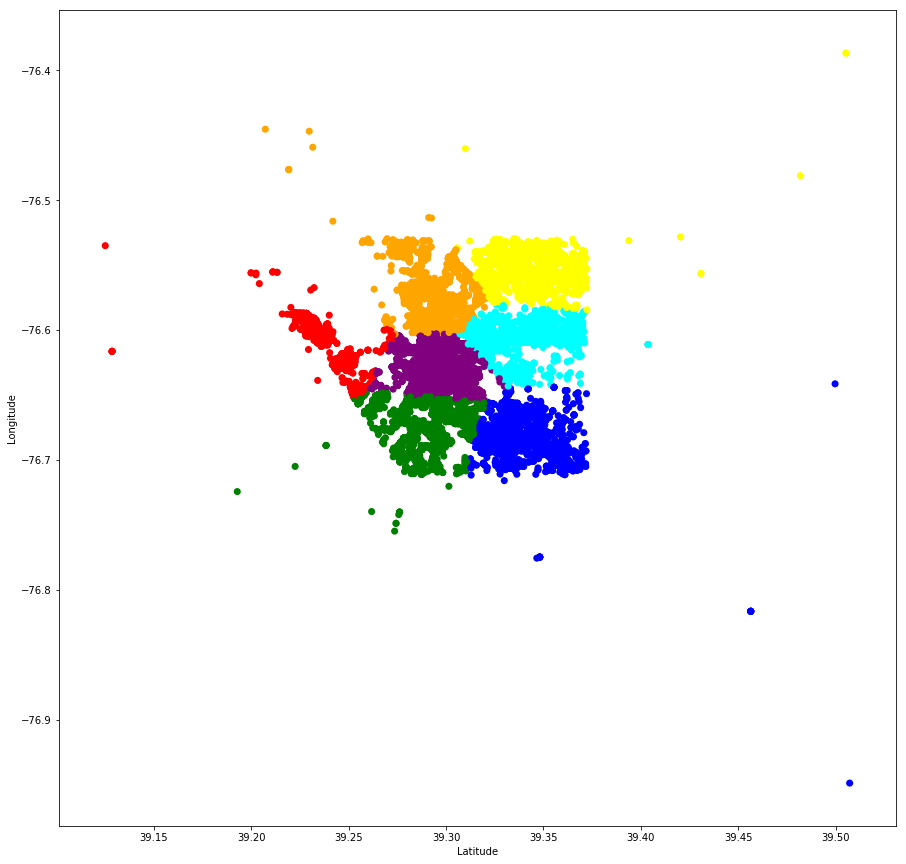

In [229]:
#color based on cluster
res=results[1]
#coloring with up to 16 colors
#this is the order of colors assigned to cluster values from 0 to 15:
#red, green, yellow, blue, orange, purple, cyan, magenta, lime, pink, black, maroon, brown, lavender, grey, navy
#using this website as color resource https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
col = np.where(res==0,'red',np.where(res==1,'green',np.where(res==2,'yellow',
    np.where(res==3,'blue',np.where(res==4,'orange',np.where(res==5,'purple',
    np.where(res==6,'cyan',np.where(res==7,'magenta',np.where(res==8,'lime',np.where(res==9,'pink',
    np.where(res==10,'black',np.where(res==11,'maroon',np.where(res==12,'brown',np.where(res==13,'lavender',
    np.where(res==14,'grey','navy')))))))))))))))

propertyDestruction.plot.scatter(x='Latitude', y='Longitude', c=col, s=50, linewidth=0, figsize=(15,15))

### Now predictions of liquor clusters based on destruction of property crime clusters:

In [230]:
prediction = km.predict(LiquorData[['Latitude', 'Longitude']])

results2 = pd.DataFrame([LiquorData[['Latitude', 'Longitude']].index,prediction]).T

results2[1].value_counts()

5    709
4    695
6    227
1    120
2    114
3    104
0     96
Name: 1, dtype: int64

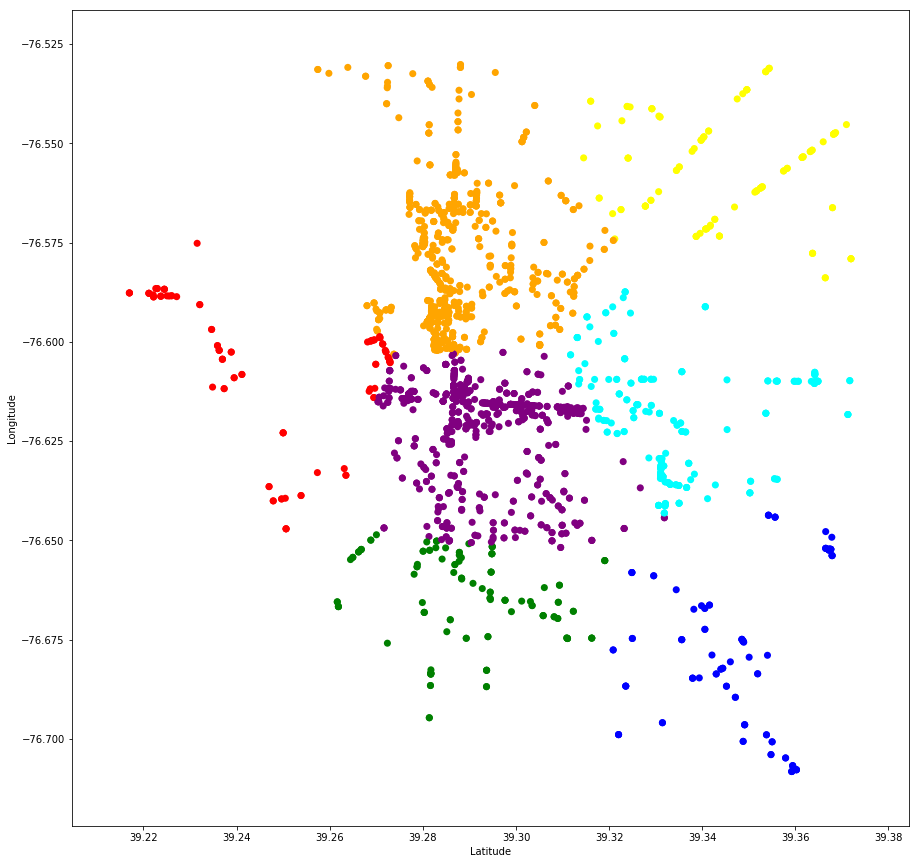

In [231]:
#color based on cluster
res=results2[1]
#coloring with up to 16 colors
#this is the order of colors assigned to cluster values from 0 to 15:
#red, green, yellow, blue, orange, purple, cyan, magenta, lime, pink, black, maroon, brown, lavender, grey, navy
#using this website as color resource https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
col = np.where(res==0,'red',np.where(res==1,'green',np.where(res==2,'yellow',
    np.where(res==3,'blue',np.where(res==4,'orange',np.where(res==5,'purple',
    np.where(res==6,'cyan',np.where(res==7,'magenta',np.where(res==8,'lime',np.where(res==9,'pink',
    np.where(res==10,'black',np.where(res==11,'maroon',np.where(res==12,'brown',np.where(res==13,'lavender',
    np.where(res==14,'grey','navy')))))))))))))))

LiquorData.plot.scatter(x='Latitude', y='Longitude', c=col, s=50, linewidth=0, figsize=(15,15))

### Once again high correlation between liquor establishments and destruction of property crimes. Crime districts are in order 5 4 1 6 while liquor districts are in order 5 4 6 1. Furthermore, the 5 and 4 districts stand above all other districts at 2k + crimes each out of the sample and around 700 liquor establishments each. Thus, there is a strong relationship between liquor/ drinking and destruction of property. 8583/12631 = 67.95 % of the crimes happen in those top 4 clusters and 1751/2065 = 87.49 % of liquor licenses being there. If we just look at the top 2 clusters 5101/12631 = 40.38 % of crime and 1404/2065 = 67.99 % of liquor. Either way there is a strong correlation demonstrated between the center and north center districts liquor licenses and property destruction crimes, as well as fairly strong correlations in the other clusters. This may be one of the strongest relationships though once again this methodology of looking at clusters does not give concrete results like some other algorithms might. Furthermore, once again, the clusters are not the best with this messy data. However, the fact that the cluster members mirror each other so closely leads to an intuitive expectation that property destruction and liquor establishments are indeed closely correlated. One can already see that at the least more liquor is a good predictor of more property destruction, even if one does not see the extent to which this is an accurate predictor. In fact, this relationship is the most linear of the ones we've seen considering that the clusters are almost in order. 

### As a last experiment, all 700 thousand plus crimes will be predicted and graphed into the liquor clusters after we first optimize them via performance metrics. This will look at the crime to liquor relationship through a new lens since here one can get the optimal liquor clusters (since liquor data is a small sample), yet still plot every single crime datum unlike the past experience of optimizing clusters by crime first. The past attempt forced a 30 k crime sample since silhouette would otherwise take too long but clustering by liquor changes all of that. 

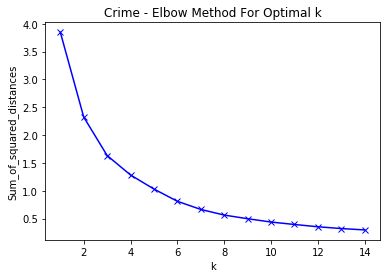

In [232]:
#no real elbow. smooth curve
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(LiquorData[['Latitude', 'Longitude']])
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Crime - Elbow Method For Optimal k')
plt.show()

In [233]:
for n_clusters in range(2, 30):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(LiquorData[['Latitude', 'Longitude']])
    centers = clusterer.cluster_centers_

    score = silhouette_score(LiquorData[['Latitude', 'Longitude']], preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.36460492935618594)
For n_clusters = 3, silhouette score is 0.37787956650895266)
For n_clusters = 4, silhouette score is 0.3671705947709843)
For n_clusters = 5, silhouette score is 0.39202552908948274)
For n_clusters = 6, silhouette score is 0.41519774582315305)
For n_clusters = 7, silhouette score is 0.44261962902673857)
For n_clusters = 8, silhouette score is 0.40729240071138706)
For n_clusters = 9, silhouette score is 0.41028203420279163)
For n_clusters = 10, silhouette score is 0.41980277868917576)
For n_clusters = 11, silhouette score is 0.42091120391766507)
For n_clusters = 12, silhouette score is 0.42303816706311026)
For n_clusters = 13, silhouette score is 0.42139407206353086)
For n_clusters = 14, silhouette score is 0.43320793007443265)
For n_clusters = 15, silhouette score is 0.44885855047189926)
For n_clusters = 16, silhouette score is 0.4427216342045274)
For n_clusters = 17, silhouette score is 0.43310808006630724)
For n_clusters = 1

### A k value of 27 or 19 appears best at least as per the metrics we have been using. 27 is slightly better but using 19 to be a little more reasonable in terms of not using an excessively high k value. 

### Plotting said value's clusters 

In [237]:
# Using sklearn
km = KMeans(n_clusters=19)
km.fit(LiquorData[['Latitude', 'Longitude']])
# Get cluster assignment labels
labels = km.labels_
# Format results as a DataFrame
results = pd.DataFrame([LiquorData[['Latitude', 'Longitude']].index,labels]).T

#counter of items per cluster
results[1].value_counts()

0     334
3     328
8     228
15    147
14    138
12    126
9     109
17     95
6      84
1      73
11     72
4      54
10     45
7      44
16     39
18     39
5      38
2      38
13     34
Name: 1, dtype: int64

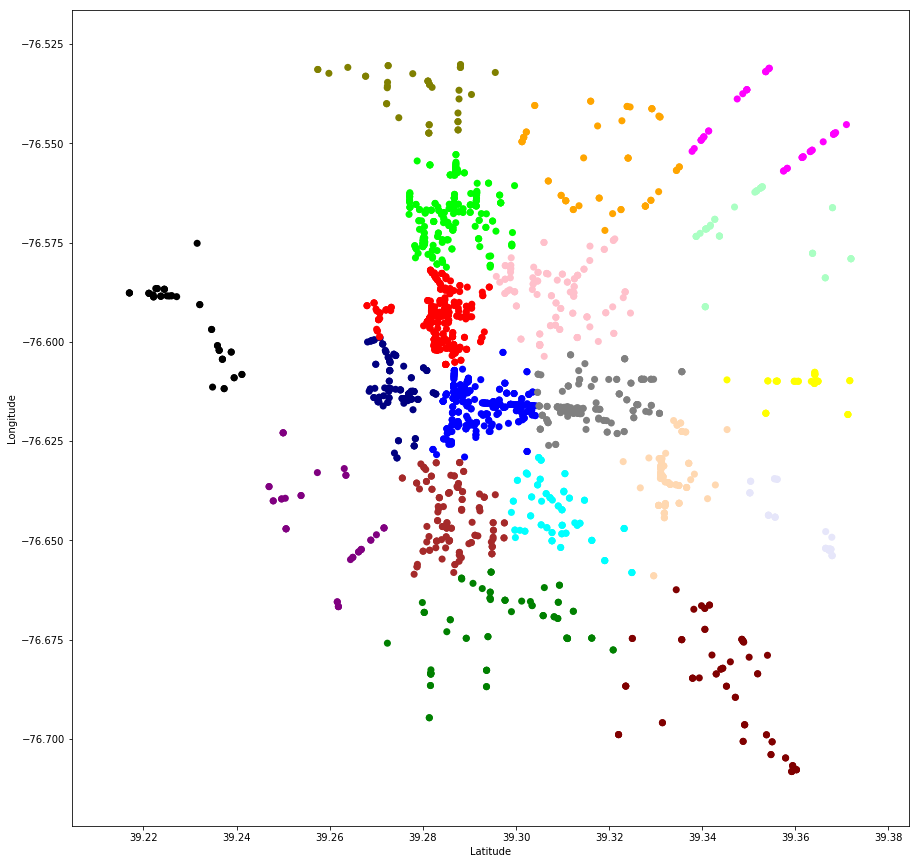

In [241]:
#color based on cluster
res=results[1]
#coloring with up to 19 colors
#this is the order of colors assigned to cluster values from 0 to 18:
#red, green, yellow, blue, orange, purple, cyan, magenta, lime, pink, black, maroon, brown,
#lavender, grey, navy, olive, apricot, mint
#using this website as color resource https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
col = np.where(res==0,'red',np.where(res==1,'green',np.where(res==2,'yellow',
    np.where(res==3,'blue',np.where(res==4,'orange',np.where(res==5,'purple',
    np.where(res==6,'cyan',np.where(res==7,'magenta',np.where(res==8,'lime',np.where(res==9,'pink',
    np.where(res==10,'black',np.where(res==11,'maroon',np.where(res==12,'brown',np.where(res==13,'lavender',
    np.where(res==14,'grey',np.where(res==15,'navy',np.where(res==16,'olive',
    np.where(res==17,'#ffd8b1','#aaffc3'))))))))))))))))))

LiquorData.plot.scatter(x='Latitude', y='Longitude', c=col, s=50, linewidth=0, figsize=(15,15))

### Now predicting amount of crime per liquor cluster: 

In [242]:
prediction = km.predict(CrimeDataNoOutlier[['Latitude', 'Longitude']])

results2 = pd.DataFrame([CrimeDataNoOutlier[['Latitude', 'Longitude']].index,prediction]).T

results2[1].value_counts()

11    73111
1     68492
6     66162
9     62134
12    56173
3     55154
14    46938
8     41523
4     38892
10    30149
2     27193
0     26906
5     24036
18    21926
7     19900
16    16657
17    14586
15    14090
13     5989
Name: 1, dtype: int64

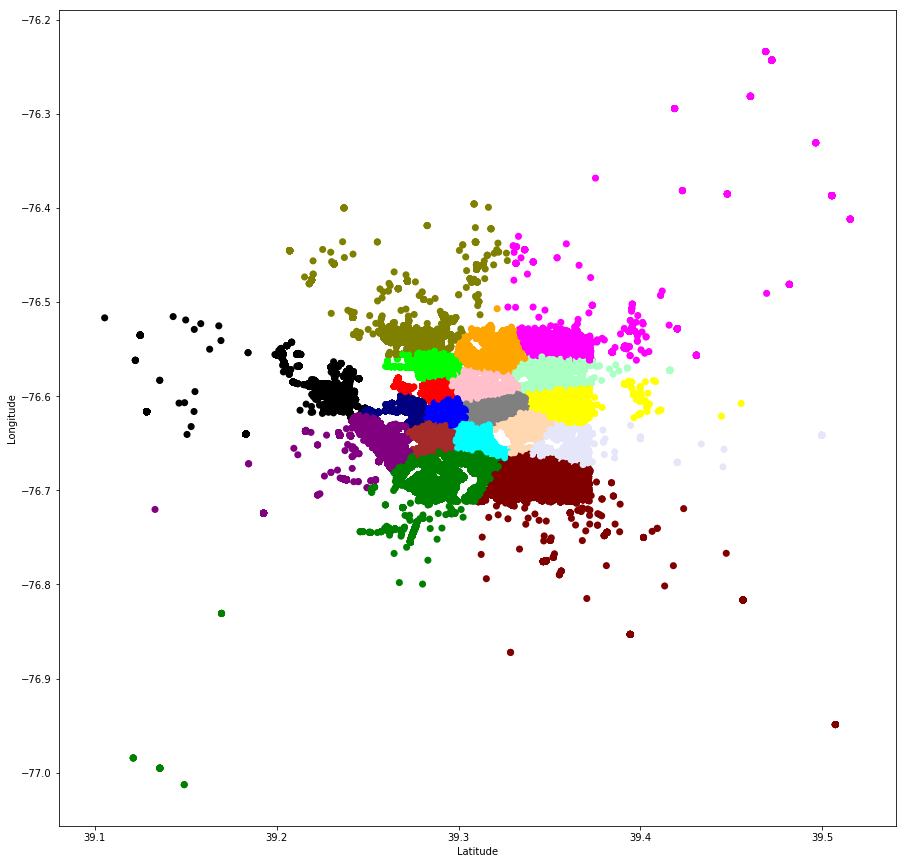

In [244]:
#color based on cluster
res=results2[1]
#coloring with up to 19 colors
#this is the order of colors assigned to cluster values from 0 to 18:
#red, green, yellow, blue, orange, purple, cyan, magenta, lime, pink, black, maroon, brown,
#lavender, grey, navy, olive, apricot, mint
#using this website as color resource https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
col = np.where(res==0,'red',np.where(res==1,'green',np.where(res==2,'yellow',
    np.where(res==3,'blue',np.where(res==4,'orange',np.where(res==5,'purple',
    np.where(res==6,'cyan',np.where(res==7,'magenta',np.where(res==8,'lime',np.where(res==9,'pink',
    np.where(res==10,'black',np.where(res==11,'maroon',np.where(res==12,'brown',np.where(res==13,'lavender',
    np.where(res==14,'grey',np.where(res==15,'navy',np.where(res==16,'olive',
    np.where(res==17,'#ffd8b1','#aaffc3'))))))))))))))))))

CrimeDataNoOutlier.plot.scatter(x='Latitude', y='Longitude', c=col, s=50, linewidth=0, figsize=(15,15))

### Obviously once again there is no relationship between all kinds of crime and presence of liquor establishments. Looking at the counts of cluster members, the sizes of crime clusters vs liquor clusters are completely different. This was to be expected but was still a useful way to double check if our results had been in any way skewed by use of a 30 k sample out of all 710 k + crimes. We did still find situations where specific kinds of crimes had some correlation to presence of liquor. Quantifying said relationship would be an interesting next step but even categorizing mutual liquor and crime clusters has been a useful insight and visualization of the relationship. 

# Conclusion:
## It has been found that general crime does not predict presence of liquor establishments and vice versa. However, presence of liquor establishments has been found to reflect on destruction of property crimes, auto accident crimes, intoxication crimes, disorderly conduct crimes, and assault crimes. A relationship was not found with narcotics crimes. This makes a lot of sense but seeing statistical and cluster confirmation does a lot to support the relationships via correlation as well as giving visuals of density of crime and liquor problems. This exact density may prove useful for determining sort of critical masses of liquor establishments which result in unacceptable crime rates. One could then decide upon zoning or laws to limit liquor licenses. However, correlation is not always proof of causation and further study is necessary. For prediction or calculation of said density, one could eventually use the clusters to construct voroni diagrams and calculate distances on the planet's surface from longitude and latitude values. By converting longitude and latitude to miles or meters one would now have a scaled distance whereas normaly a degree or longitude vs latitude is not created equally. This scaled data would be better suited for calculating area of the sections for each cluster in the voroni diagram. Using the instance of crime or liquor licenses or any other data/ divided by the area for each cluster, one could then calculate density and perhaps better describe how well liquor vs certain crimes predict each other as well as finding how common crimes or liquor are in certain areas in relation to the square mileage. 